## Project #2: Derivative discontinuity and IP theorems in the extended N-centered ensemble formalism - exact insights from the Hubbard dimer

### Goals of the project:

#### 1. Explore the vHxc derivative discontinuity in the Hubbard dimer
#### 2. Evaluate the ionization potentials, in particular, $I_{0}^{N}$ and $I_{1}^{N}$ at the EEXX level of approximation

### Objective 1: Visualize the vHxc derivative discontinutiy in the Hubbard dimer

In this script, we are going to implement all the equations pertaining to the
extended N-centered eDFT formalism in the Hubbard Dimer case.

Ensemble energy in eN-centered-eDFT

$$ E^{\boldsymbol\eta} = \bigg( 1 - {\tt w} - \frac{\xi_-}{2} \bigg) E_{0}^{N} + {\xi_-}E_{0}^{N-1} + {\tt w} E_{1}^{N} $$

The corresponding ensemble density is then equal to

$$ n^{\boldsymbol\eta} = \bigg( 1 - {\tt w} - \frac{\xi_-}{2} \bigg) n_{\Psi_0^N} + {\xi_-}n_{\Psi_0^{N-1}} + {\tt w} n_{\Psi_1^N} $$

The objective is to visualize the derivative discontinuity in the Hartree-exchange-correlation (Hxc) potential in the Hubbard dimer, when we cross from the bare left N-centered ensemble where $\boldsymbol\eta = (\xi_-,0)$ to the full eN-centered ensemble including the first excited state, so that the collective weight is equal to $\boldsymbol\eta = (\xi_-,\tt w)$. If the implementation is correct, the derivative discontinuity when extrapolating to ${\tt w} \rightarrow 0^+$ should be totally absorbed by the GOK weight derivative of the ensemble Hxc energy:

$$v_{Hxc}^{{\tt w} \rightarrow 0^+}(\mathbf{r}) - v_{Hxc}^{{\tt w} = 0}(\mathbf{r}) \equiv
\dfrac{\partial E_{Hxc}^{{\tt w}}[n]}{\partial {\tt w}} \biggr\rvert_{{\tt w} = 0}
$$

In [1]:
# Python imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from math import *
from scipy.optimize import fminbound
import ipywidgets as widgets
from ipywidgets import interactive
import scipy.ndimage as ndimage
from fractions import Fraction
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/var/folders/16/m694ylkj08l7r2p41k1b6_ch0000gn/T/ipykernel_6236/2870128660.py:1: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [3]:
# Individual energies and ensemble energy
# First, we define the subroutine to compute the "r" and "theta" parameters
def r(twot,bigu,deltav):
    """
    The lowercase r parameter.
    """
    return sqrt(3*((twot)**2+deltav**2)+bigu**2)
def theta(twot,bigu,deltav,r):
    """
    The lowercase theta parameter.
    """
    return (1.0/3.0)*acos((9.0*bigu*((deltav**2)-2*((twot/2)**2))-bigu**3)/(r**3))

In [4]:
# Then, we define the function to calculate the ensemble and individual energies
def E(twot,bigu,deltav,xim,w):
    
    """
    Calculates the ground-state (N,N-1) el and the 1st excited state (N-el) energies of the two-electron system 
    via an analytical expression. Also calculates the corresponding eN-centered ensemble energy.
    
    Returns a dictionary with the following entries:
    
    E_ens: ensemble energy
    E0_N: N-electron ground-state energy
    E0_Nm1: Nminus1-electron ground-state energy
    E1_N: N-electron excited state energy
    
    Parameters:
    
    twot: two times the t (hopping parameter)
    of the Hubbard model
    
    bigu: the site repulsion energy of the Hubbard model
    
    deltav: the site potential of the Hubbard model
    
    xim: weight for the N-1 electron ground state
    
    w: weight for the 1st excited state
    """
    
    # First, individual energies are calculated
    
    E0_N = (2.0/3.0)*(bigu) + (2.0/3.0)*(r(twot,bigu,deltav))*\
         cos(theta(twot,bigu,deltav,r(twot,bigu,deltav)) + ((2*pi)/3))
    
    E1_N = (2.0/3.0)*(bigu) + (2.0/3.0)*(r(twot,bigu,deltav))*\
         cos(theta(twot,bigu,deltav,r(twot,bigu,deltav)) + ((2*pi)/3)*2)
    
    E0_Nm1 = -(1/2)*sqrt((twot**2) + deltav**2 )

    # Then, calculate the ensemble energy
        
    E_ens = (1-w-(xim/2))*E0_N + xim*E0_Nm1 + w*E1_N
        
    # Return a dictionary with three entries in order: Ensemble energy, GS energy, 1st e.s. energy
    
    return {"E_ens":E_ens,"E0_N":E0_N,"E0_Nm1":E0_Nm1,"E1_N":E1_N}

In [5]:
# We also define the Kohn-Sham energy for the noninteracting system
def EKS(twot,bigu,deltav,xim,w):
    
    """
    Calculates the ground-state (N,N-1) el and the 1st excited state (N-el) energies of the two-electron system 
    via an analytical expression. Also calculates the corresponding eN-centered ensemble energy.
    In this case, the 2-electron system is a NONINTERACTING system.
    
    Returns a dictionary with the following entries:
    
    E_ens: ensemble energy
    E0_N: N-electron ground-state energy
    E0_Nm1: Nminus1-electron ground-state energy
    E1_N: N-electron excited state energy
    
    Parameters:
    
    twot: two times the t (hopping parameter)
    of the Hubbard model
    
    bigu: the site repulsion energy of the Hubbard model
    
    deltav: the site potential of the Hubbard model
    
    xim: weight for the N-1 electron ground state
    
    w: weight for the 1st excited state
    """
    
    # First, we compute the HOMO energy
    
    # Then, we compute all the individual energies
    
    eH = -(1/2)*sqrt(twot**2 + deltav**2)
    
    E0_N = 2*eH
    
    E0_Nm1 = -eH
    
    E1_N = 0
    
    # And finally, we compute the ensemble energy
    
    E_ens = (1-w)*E0_N
    
    # Return a dictionary with three entries in order: Ensemble energy, GS energy, 1st e.s. energy
    
    return {"E_ens":E_ens,"E0_N":E0_N,"E0_Nm1":E0_Nm1,"E1_N":E1_N}

In [6]:
# Computing the ensemble and individual densities
def Density(twot,bigu,deltav,xim,w):
    
    """
    Calculates the ensemble density and the individual densities of the Hubbard Dimer.
   
    The formulas to calculate the individual densities come from the Hellmann-Feynman theorem.
    
    Returns a dictionary with the following entries:
    
    n_ens: ensemble density
    n0_N: N-electron ground-state density
    n0_Nm1: N-electron first excited state density
    n1_N: N-electron first excited state density
    
    Parameters:
    
    twot: two times the t (hopping parameter)
    of the Hubbard model
    
    bigu: the site repulsion energy of the Hubbard model
    
    deltav: the site potential of the Hubbard model
    
    xim: weight of the N-1 electron ground state
    
    w: weight for the 1st excited state
    """
    
    # Individual GS and 1st e.s. densities first
    
    E0_N = E(twot,bigu,deltav,xim,w)["E0_N"]
    E1_N = E(twot,bigu,deltav,xim,w)["E1_N"]
    t = twot/2
    
    n0_N =  1 - (2*deltav*E0_N)/(3*(E0_N**2)-4*bigu*E0_N+bigu**2-4*(t**2)-deltav**2)
    
    n1_N =  1 - (2*deltav*E1_N)/(3*(E1_N**2)-4*bigu*E1_N+bigu**2-4*(t**2)-deltav**2)
    
    n0_Nm1 = (1/2)*(1 + (deltav/np.sqrt(4*(t**2) + deltav**2)))
    
    # Then, the ensemble density.
    
    n_ens = (1 - w - (xim/2))*n0_N + xim*n0_Nm1 + w*n1_N
    
    return {"n_ens":n_ens,"n0_N":n0_N,"n0_Nm1":n0_Nm1,"n1_N":n1_N}

#### Testing some ensemble density approximation for the Hubbard dimer in the strongly correlated regime

Here we test some taylor expansions of electron densities in the regime $t << \Delta v_{ext} << U$ to see how much do different terms contribute to the total ensemble density.

The exact N-1 electron ground state density is equal to:

$$ n_{\Psi_{0}^{N-1}} = \frac{1}{2}\big(1 + \frac{\Delta v_{ext}}{\sqrt{4t^2 + \Delta v_{ext}^2}}\big) \approx 1 - \frac{t^2}{\Delta v_{ext}^2}$$

The GOK ensenbme density (in the $t/U$ expansion around 0) is, up to the second order, equal to:

$$ n^{\tt w} = 1 + {\tt w} + \frac{2(t/U)^{2}}{(1 - (\Delta v_{ext}/U)^{2})^{2}}\bigg[ \frac{4(1- {\tt w})(\Delta v_{ext}/U) }{(1 + (\Delta v_{ext}/U))^{2}} - {\tt w}\bigg] + \mathcal{O}\bigg(\big(\frac{t}{U}\big)^3\bigg)$$

We will test two approximations, namely the first and the second order one:

$$ n^{\tt w}_{appr1} = 1 + {\tt w} $$

$$ n^{\tt w}_{appr2} = 1 + {\tt w} + \frac{2(t/U)^{2}}{(1 - (\Delta v_{ext}/U)^{2})^{2}}\bigg[ \frac{4(1- {\tt w})(\Delta v_{ext}/U) }{(1 + (\Delta v_{ext}/U))^{2}} - {\tt w}\bigg] $$

In [7]:
twot = 1
bigu = 5
deltavlist = np.linspace(0.01,5,501)
weightlist = np.linspace(0,0.5,501)

In [8]:
def n_ens_approx2(twot,bigu,deltav,w):
    
    t = twot/2
    
    addendum = 2*( ((t/bigu)**2)/((1 - (deltav/bigu)**2)**2) )*(4*(1-w)*(deltav/bigu)/((1 + (deltav/bigu))**2) - w)
    
    return 1 + w + addendum

In [9]:
n0_Nlist = [Density(twot,bigu,deltav,0,0)["n0_N"] for deltav in deltavlist]
n1_Nlist = [Density(twot,bigu,deltav,0,0)["n1_N"] for deltav in deltavlist]
n0_Nm1list = [Density(twot,bigu,deltav,0,0)["n0_Nm1"] for deltav in deltavlist]
n0_Nm1approx = [1 - (0.5/deltav)**2 for deltav in deltavlist]

nens = [Density(twot,bigu,1,0,w)["n_ens"] for w in weightlist]

nens_approx_1 = [1 + w for w in weightlist]


nens_approx_2 = [n_ens_approx2(1,5,1,w) for w in weightlist]

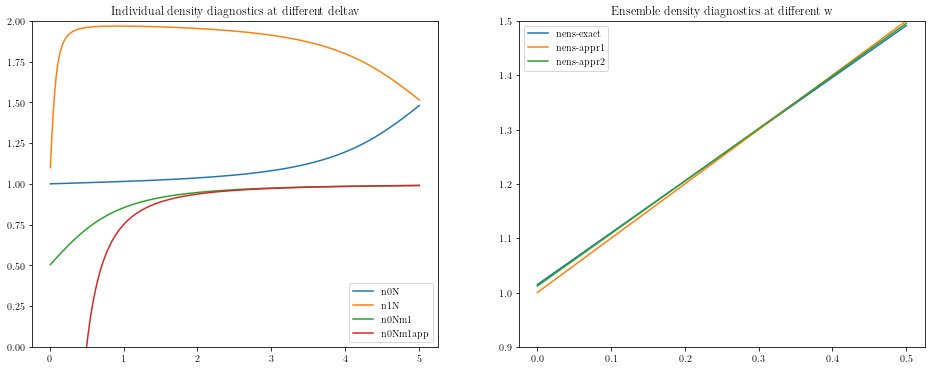

In [10]:
fig,ax = plt.subplots(figsize=(16,6),ncols=2)

ax[0].set_ylim(0,2)
ax[1].set_ylim(0.9,1.5)


ax[0].set_title("Individual density diagnostics at different deltav")
ax[1].set_title("Ensemble density diagnostics at different w")

ax[0].plot(deltavlist,n0_Nlist,label="n0N")
ax[0].plot(deltavlist,n1_Nlist,label="n1N")
ax[0].plot(deltavlist,n0_Nm1list,label="n0Nm1")
ax[0].plot(deltavlist,n0_Nm1approx,label="n0Nm1app")

#ax.axhline(y=((1/2) + np.sqrt(2)/4),color="black")

ax[1].plot(weightlist,nens,label="nens-exact")
ax[1].plot(weightlist,nens_approx_1,label="nens-appr1")
ax[1].plot(weightlist,nens_approx_2,label="nens-appr2")

ax[0].legend()
ax[1].legend()

Now we will do some Kohn-Sham potential diagnostics for the exact ensemble density and the two approximations

$$ \Delta v_{KS}^{\tt w}(n) = \frac{2(n-1)t}{\sqrt{(1 - {\tt w})^2 - (1 - n)^2}}$$

In [11]:
def dv_KS(twot,bigu,deltav,n,w):
    
    result = twot*(n-1)/sqrt((1-w)**2 - (1-n)**2)
    
    return result

In [12]:
dvKS_exact = [dv_KS(twot,bigu,1,Density(twot,bigu,1,0,w)["n_ens"],w) for w in weightlist]
dvKS_approx1 = [dv_KS(twot,bigu,1,1+w,w) for w in weightlist[:-1]]
dvKS_approx2 = [dv_KS(twot,bigu,1,n_ens_approx2(twot,bigu,1,w),w) for w in weightlist[:-1]]
dvKS_exact2 = [deltav_Hxc_eta(twot,bigu,1,0,w) + 1 for w in weightlist]

NameError: name 'deltav_Hxc_eta' is not defined

NameError: name 'dvKS_exact2' is not defined

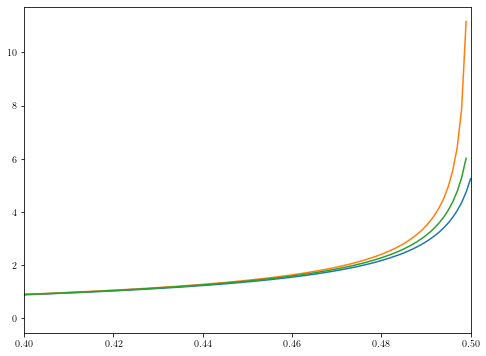

In [13]:
fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlim(0.4,0.5)

ax.plot(weightlist,dvKS_exact,label="dV-KS \: exact")
ax.plot(weightlist[:-1],dvKS_approx1,label="dv-KS nens-appr1")
ax.plot(weightlist[:-1],dvKS_approx2,label="dv-KS nens-appr2")
ax.plot(weightlist,dvKS_exact2,label="dV-KS \: exact (equation 2)")

plt.title("deltav-KS diagnostics")
plt.legend();

The ensemble Hartree-exchange-correlation (Hxc) functional is then defined as:

$$ E_{\rm Hxc}^{\boldsymbol \eta}(n) = F^{\boldsymbol \eta}(n) - T_{\rm s}^{\boldsymbol \eta}(n) $$

where the universal functional is

$$ F^{\boldsymbol \eta}(n) = \sup_{\Delta v} \left\{  \bigg( 1 - {\tt w} - \frac{\xi_-}{2} \bigg) E_{0}^{N}(\Delta v) + {\xi_-}E_{0}^{N-1}(\Delta v) + {\tt w} E_{1}^{N}(\Delta v) - \Delta v (1-n)\right\} $$

and the noninteracting kinetic energy functional

$$ T_{s}^{\boldsymbol \eta}(n) = \sup_{\Delta v} \left\{  \bigg( 1 - {\tt w} - \frac{\xi_-}{2} \bigg) \mathcal{E}_{0}^{N}(\Delta v) + {\xi_-}\mathcal{E}_{0}^{N-1}(\Delta v) + {\tt w} \mathcal{E}_{1}^{N}(\Delta v) - \Delta v (1-n)\right\} $$

which actually has an analytcal expression.

$$ T_{s}^{\boldsymbol \eta}(n) = -2t\sqrt{(1-w)^2 - (1-n)^2} $$

But nevertheless, we are going to compute both $F^{\boldsymbol \eta}(n)$ and $T_{s}^{\boldsymbol \eta}(n)$ numerically, via Lieb maximization, so that we have a balanced commputation for the Hartree-Exchange-Correlation Functional.<span style="color:red;font-weight:bold;">NOT ANYMORE! We do it analytically, since it is simpler, by using the following compact expression for the Hartree-exchange-correlation (Hxc) functional:</span>

$$ E_{Hxc}^{\boldsymbol \eta}(n) = \sup_{\Delta v} \left\{ (1-\frac{\xi_-}{2}-w)E_{0}^{N}(\Delta v) + \xi_- E_{0}^{N-1}(\Delta v) + w E_{1}^{N}(\Delta v) - \Delta v (1-n(\Delta v)) \right\} \bigg\rvert_{\Delta v = \Delta v_{ext}}  + 2t\sqrt{(1-w)^{2} - (1-n)^{2}}$$

In [14]:
def EHxc_eta(twot,bigu,deltav,xim,w):
    
    # The hartree-exchange-correlation functional
    ### NOTE: IT IS ONLY DEFINED FOR A GIVEN ENSEMBLE DENSITY, IMPLICITLY AS A FUNCTION OF ALL THE PARAMETERS!
    
    elist = E(twot,bigu,deltav,xim,w)
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    
    F_eta = (1-(xim/2)-w)*elist["E0_N"] + xim*elist["E0_Nm1"] + w*elist["E1_N"] - deltav*(1-n_ens)
    
    Ts_eta = -twot*(sqrt( (1-w)**2 - (1-n_ens)**2 ))
    
    result = F_eta - Ts_eta
    
    return result

In [15]:
def EHxc_eta_opt(twot,bigu,n,xim,w):
    
    # The numerically optimized version of the hartree-exchange-correlation functional
    
    # First, we numerically optimize the universal functional
    deltav_max = fminbound(lambda x: -(E(twot,bigu,x,xim,w)["E_ens"] + x*(n-1)), -1000, 1000 )
    
    F_ens = E(twot,bigu,deltav_max,xim,w)["E_ens"] + deltav_max*(n-1)
    
    # Then, we optimize the ensemble KS functional
    deltavKS_max = fminbound(lambda x: -(EKS(twot,bigu,x,xim,w)["E_ens"] + x*(n-1)), -1000, 1000 )
    
    Ts_ens = EKS(twot,bigu,deltavKS_max,xim,w)["E_ens"] + deltavKS_max*(n-1)
    
    # And finally, we compute the desired result, i.e. the Hartree-Exchange-correlation functional
    result = F_ens - Ts_ens
    
    return result

In [16]:
# Now we do some testing, to see whether or not these two functionals are the same for some given ensemble
# density.
twot = 1
bigu = 5
deltav = 1
w = 0.1
max_xim = 2*(1-2*w)
ximlist = np.linspace(0,max_xim,201)

In [17]:
hxclist = [EHxc_eta(twot,bigu,deltav,xim,w) for xim in ximlist]
hxcoptlist = [EHxc_eta_opt(twot,bigu,Density(twot,bigu,deltav,xim,w)["n_ens"],xim,w) for xim in ximlist]

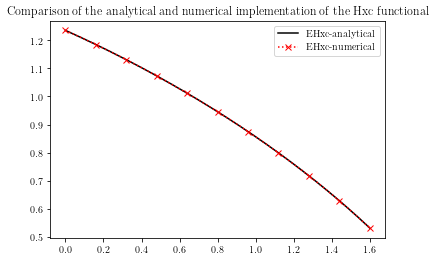

In [18]:
plt.plot(ximlist,hxclist,color="k",label="EHxc-analytical")
plt.plot(ximlist,hxcoptlist,linestyle=":",marker="x",markevery=20,color="r",label="EHxc-numerical")
plt.title("Comparison of the analytical and numerical implementation of the Hxc functional")
plt.legend();

Alles gut! Now, we are ready to compute the weight derivatives of the ensemble Hxc energy.

In [19]:
### The ensemble weight derivatives of the Hartree-exchange-correlation functional
### Derivative wrt to xim
### And Derivative wrt to w

### NOTICE: BOTH FUNCTIONALS ARE ONLY DEFINED FOR A GIVEN ENSEMBLE DENSITY!!!

def dw_EHxc_eta(twot,bigu,deltav,xim,w):
    
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    
    E1_N = E(twot,bigu,deltav,xim,w)["E1_N"]
    E0_N = E(twot,bigu,deltav,xim,w)["E0_N"]
    
    result = E1_N - E0_N - (twot*(1-w))/sqrt((1-w)**2 - (1-n_ens)**2)
    
    return result

def dxim_EHxc_eta(twot,bigu,deltav,xim,w):
    
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    
    E0_Nm1 = E(twot,bigu,deltav,xim,w)["E0_Nm1"]
    E0_N = E(twot,bigu,deltav,xim,w)["E0_N"]
    
    result = E0_Nm1 - (1/2)*E0_N
    
    return result
    

In [20]:
# The Hartree-exchange-correlation (Hxc) potential

### AGAIN, ONLY DEFINED FOR A GIVEN ENSEMBLE DENSITY

def deltav_Hxc_eta(twot,bigu,deltav,xim,w):
    
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    
    dvKS = (twot*(n_ens - 1))/sqrt((1-w)**2 - (1-n_ens)**2)
    
    dvEXT = deltav
    
    # And finally, we can compute the result
    result = dvKS - dvEXT
    
    return result

In [21]:
Density(1,5,1,0,0)["n0_N"]

1.014730903049479

In [22]:
Density(1,5,1,0,0)["n1_N"]

1.9675626395405068

### The Hartree-exchange-correlation potential on site 1

This is the variable we are looking for when we're trying to visualize the derivative discontinuity

In [23]:
def vHxc_xim(twot,bigu,deltav,xim):
    
    w = 0
    
    n_xim = Density(twot,bigu,deltav,xim,w)["n_ens"]
    dvHxc_xim = deltav_Hxc_eta(twot,bigu,deltav,xim,w)
    
    EHxc_xim = EHxc_eta(twot,bigu,deltav,xim,w)
    
    dxim_EHxc_xim = dxim_EHxc_eta(twot,bigu,deltav,xim,w)
    
    result = (1/2)*(dvHxc_xim*n_xim + EHxc_xim - (2+xim)*dxim_EHxc_xim)
    
    return result

def vHxc_w(twot,bigu,deltav,w):
    
    xim = 0
    
    n_w = Density(twot,bigu,deltav,xim,w)["n_ens"]
    dvHxc_w = deltav_Hxc_eta(twot,bigu,deltav,xim,w)
    
    EHxc_w = EHxc_eta(twot,bigu,deltav,xim,w)
    
    dw_EHxc_w = dw_EHxc_eta(twot,bigu,deltav,xim,w)
    
    dxim_EHxc_xim = dxim_EHxc_eta(twot,bigu,deltav,xim,w)
    
    result = (1/2)*(dvHxc_w*n_w + EHxc_w + (2-w)*dw_EHxc_w) - dxim_EHxc_xim
    
    return result

### The Hx approximation to the Hxc potential on site 1

We are evaluating the Hx potential at exact density, that means we are going to study functional-driven errors.

In [24]:
def vHx_xim(twot,bigu,deltav,xim):
    
    w = 0
    
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    dvHxc_xim = deltav_Hxc_eta(twot,bigu,deltav,xim,w)   
    
    dxim_EHx = -(bigu/4)*(1 + ( (1-n_ens)/(1-w) )**2)
    
    dw_EHx = (bigu/2)*(1 - ((1 + 3*w + xim)*((1-n_ens)**2)/((1-w)**3)) )
    
    EHX = (bigu/2)*(1 + w - (xim/2) + (1-3*w-(xim/2))*(((1-n_ens)/(1-w))**2) )
    
    
    result = (1/2)*(dvHxc_xim*n_ens + EHX - (2+xim)*dxim_EHx)
    
    return result

def vHx_w(twot,bigu,deltav,w):
    
    xim = 0
    
    #n_ens = 1+w
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    dvHxc_w = deltav_Hxc_eta(twot,bigu,deltav,xim,w)
    
    dxim_EHx = -(bigu/4)*(1 + ( (1-n_ens)/(1-w) )**2)
    
    dw_EHx = (bigu/2)*(1 - ((1 + 3*w + xim)*((1-n_ens)**2)/((1-w)**3)) )
    
    EHX = (bigu/2)*(1 + w - (xim/2) + (1-3*w-(xim/2))*(((1-n_ens)/(1-w))**2) )
    
    result = (1/2)*(dvHxc_w*n_ens + EHX + (2-w)*dw_EHx) - dxim_EHx
    
    return result
def vHx_w2(twot,bigu,deltav,w):
    
    xim = 0
    
    n_ens = 1+w
    #n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    dvHxc_w = dv_KS(twot,bigu,deltav,n_ens,w) - deltav
    
    dxim_EHx = -(bigu/4)*(1 + ( (1-n_ens)/(1-w) )**2)
    
    dw_EHx = (bigu/2)*(1 - ((1 + 3*w + xim)*((1-n_ens)**2)/((1-w)**3)) )
    
    EHX = (bigu/2)*(1 + w - (xim/2) + (1-3*w-(xim/2))*(((1-n_ens)/(1-w))**2) )
    
    result = (1/2)*(dvHxc_w*n_ens + EHX + (2-w)*dw_EHx) - dxim_EHx
    
    return result

### Figure 1: displaying the Hxc potential on site 1 for both the symmetric and the asymmetric Hubbard dimer within the strongly correlated regime

In [25]:
# Defining control variables
twot = 1
bigu = 5
deltav = 1
weightlist = np.linspace(0,2,201)

In [26]:
fig1,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10*(3/4),10))

# Hxc potential on site 1, symmetric case
hxc_xim_s = [vHxc_xim(twot,bigu,0,xim) for xim in weightlist]
hxc_w_s = [vHxc_w(twot,bigu,0,w) for w in weightlist[:51]]

# Hx potential on site 1, symmetric case
hx_xim_s = [vHx_xim(twot,bigu,0,xim) for xim in weightlist]
hx_w_s = [vHx_w(twot,bigu,0,w) for w in weightlist[:51]]

# Hxc potential on site 1, asymmetric case
hxc_xim = [vHxc_xim(twot,bigu,deltav,xim) for xim in weightlist]
hxc_w = [vHxc_w(twot,bigu,deltav,w) for w in weightlist[:51]]

# Hx potential on site 1, asymmetric case
hx_xim = [vHx_xim(twot,bigu,deltav,xim) for xim in weightlist]
hx_w = [vHx_w(twot,bigu,deltav,w) for w in weightlist[:51]]


# Now, plotting all of the stuff
ax1.plot(weightlist,hxc_xim_s,label=r"$v_{\rm Hxc}^{\xi_-}$",color="red",lw=2.0)
ax1.plot(weightlist[:51],hxc_w_s,label=r"$v_{\rm Hxc}^{\tt w}$",color="blue",lw=2.0)

ax1.plot(weightlist,hx_xim_s,label=r"$v_{\rm Hx}^{\xi_-}$",color="red",ls="-",lw=0.75,marker="x",ms=5,markevery=6)
ax1.plot(weightlist[:51],hx_w_s,label=r"$v_{\rm Hx}^{\tt w}$",color="blue",ls="-",lw=0.75,marker="x",ms=5,markevery=6)

ax2.plot(weightlist,hxc_xim,label=r"$v_{\rm Hxc}^{\xi_-}$",color="red",lw=2.0)
ax2.plot(weightlist[:51],hxc_w,label=r"$v_{\rm Hxc}^{\tt w}$",color="blue",lw=2.0)

ax2.plot(weightlist,hx_xim,label=r"$v_{\rm Hx}^{\xi_-}$",color="red",ls="-",lw=0.75,marker="x",ms=5,markevery=6)
ax2.plot(weightlist[:51],hx_w,label=r"$v_{\rm Hx}^{\tt w}$",color="blue",ls="-",lw=0.75,marker="x",ms=5,markevery=6)


ax1.set_title(r"$t = \:$"+str(twot/2)+", "+r"$U = \:$"+str(bigu)+", "+r"$\Delta v_{\rm ext} = \:$"+"0",
                          y = 1.01,
                          fontsize=20)
ax2.set_title(r"$t = \:$"+str(twot/2)+", "+r"$U = \:$"+str(bigu)+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
                          y = 1.01,
                          fontsize=20)


for ax in (ax1,ax2):
    ax.set_xlabel("ensemble weight",fontsize=20,labelpad=10)
    ax.tick_params(axis='both', direction="in", labelsize=18)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_major_locator(MaxNLocator(7))
    ax.tick_params(axis='both', which='major', pad=8)
    ax.set_ylabel(r"$v_{\rm Hxc}^{\boldsymbol\eta}$",fontsize=20,labelpad=10)
    ax.set_xlim(0,2)
    ax.set_ylim(-2,6)
    
    #GOK LIMIT
    ax.axvline(0.5,color="k",ls=":")


handles, labels = plt.gca().get_legend_handles_labels()
fig1legend = fig1.legend(handles, labels, loc='lower left',bbox_to_anchor=(0.12,-0.1),
                         ncol=4,fontsize=22,columnspacing=1,frameon=False)
plt.tight_layout()
#plt.savefig("DDiscont_final.pdf",bbox_inches="tight");

RuntimeError: latex was not able to process the following string:
b'$v_{\\\\rm Hxc}^{\\\\boldsymbol\\\\eta}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../bbca53ef31440c8ddc8e47842b6c1324.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file bbca53ef31440c8ddc8e47842b6c1324.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.19 {\rmfamily $v_{\rm Hxc}^{\boldsymbol
                                         \eta}$}
No pages of output.
Transcript written on bbca53ef31440c8ddc8e47842b6c1324.log.




RuntimeError: latex was not able to process the following string:
b'$v_{\\\\rm Hxc}^{\\\\boldsymbol\\\\eta}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../bbca53ef31440c8ddc8e47842b6c1324.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file bbca53ef31440c8ddc8e47842b6c1324.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.19 {\rmfamily $v_{\rm Hxc}^{\boldsymbol
                                         \eta}$}
No pages of output.
Transcript written on bbca53ef31440c8ddc8e47842b6c1324.log.




<Figure size 540x720 with 2 Axes>

In [ ]:
hxc_w[0]-hxc_xim[0]

In [ ]:
### Here we will analyze what happens in the asymmetric case by breaking down the equations for
### v_Hxc_xim and v_Hxc_w into several different contributions

### First, we define the appropriate functions
def vHxc_xim_allterms(twot,bigu,deltav,xim):
    
    w = 0
    
    n_xim = Density(twot,bigu,deltav,xim,w)["n_ens"]
    dvHxc_xim = deltav_Hxc_eta(twot,bigu,deltav,xim,w)
    
    EHxc_xim = EHxc_eta(twot,bigu,deltav,xim,w)
    
    dxim_EHxc_xim = dxim_EHxc_eta(twot,bigu,deltav,xim,w)
    
    term1 = dvHxc_xim*n_xim
    
    term2 = EHxc_xim
    
    term3 = -(2+xim)*dxim_EHxc_xim
    
    return {"t1":term1,"t2":term2,"t3":term3}

def vHxc_w_allterms(twot,bigu,deltav,w):
    
    xim = 0
    
    n_w = Density(twot,bigu,deltav,xim,w)["n_ens"]
    dvHxc_w = deltav_Hxc_eta(twot,bigu,deltav,xim,w)
    
    EHxc_w = EHxc_eta(twot,bigu,deltav,xim,w)
    
    dw_EHxc_w = dw_EHxc_eta(twot,bigu,deltav,xim,w)
    
    dxim_EHxc_xim = dxim_EHxc_eta(twot,bigu,deltav,xim,w)
    
    term1 = dvHxc_w*n_w
    
    term2 = EHxc_w
    
    term3 = (2-w)*dw_EHxc_w
    
    term4 = - 2*dxim_EHxc_xim
    
    return {"t1":term1,"t2":term2,"t3":term3,"t4":term4}

In [ ]:
### Second, we define the model parameters
# Defining control variables for the first plot
twot = 1
bigu = 5
deltav = 1
weightlist = np.linspace(0,2,201)

In [27]:
### Then, we plot the whole thing. We have two plots to produce

NameError: name 'vHxc_xim_allterms' is not defined

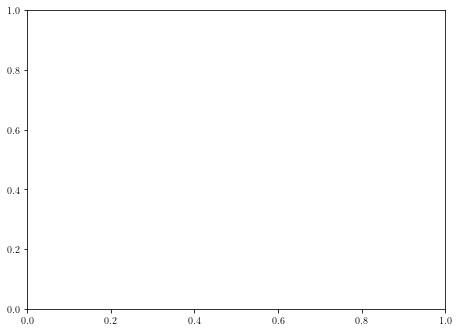

In [28]:
fig,ax = plt.subplots(figsize=(7.5,5.5))

# Hxc potential on site 1, asymmetric case
hxc_xim = [2*vHxc_xim(twot,bigu,deltav,xim) for xim in weightlist]

# Hxc potential on site 1, asymmteric case, various terms
hxc_xim_t1 = [vHxc_xim_allterms(twot,bigu,deltav,xim)["t1"] for xim in weightlist]
hxc_xim_t2 = [vHxc_xim_allterms(twot,bigu,deltav,xim)["t2"] for xim in weightlist]
hxc_xim_t3 = [vHxc_xim_allterms(twot,bigu,deltav,xim)["t3"] for xim in weightlist]

#Check if everything is okay
#allsum = [i+j+k for i,j,k in zip(hxc_xim_t1,hxc_xim_t2,hxc_xim_t3)]

ax.plot(weightlist,hxc_xim,label=r"$2v_{\rm Hxc}^{\xi_-}$",color="red",lw=2.0)

ax.plot(weightlist,hxc_xim_t1,label=r"${\Delta v}_{\rm Hxc}^{\xi_-}n^{\xi_-}$",color="red",lw=2.0,ls="--")
ax.plot(weightlist,hxc_xim_t2,label=r"$E_{\rm Hxc}^{\xi_-}(n^{\xi_-})$",color="red",lw=2.0,ls="-.")
ax.plot(weightlist,hxc_xim_t3,label=r"$-(2+\xi_-)\frac{\partial E_{\rm Hxc}^{\xi_-}(n)}{\partial \xi_-}\bigg\vert_{n=n^{\xi_-}}$",
         color="red",lw=2.0,ls=":")

# Plot the sum of all individual terms
#plt.plot(weightlist,allsum,color="black")

# Some axis parameters

ax.set_title(r"$t = \:$"+str(twot/2)+", "+r"$U = \:$"+str(bigu)+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
                          y = 1.01,
                          fontsize=20)

ax.set_xlabel(r"$\xi_-$",fontsize=20,labelpad=10)
ax.tick_params(axis='both', direction="in", labelsize=18)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(7))
ax.tick_params(axis='both', which='major', pad=8)
ax.set_xlim(0,2)

#ax.axhline(y=0,color="black")


ax.legend(fontsize=20,ncol=2,loc="lower left",bbox_to_anchor=(0,-0.6),frameon=False)

#plt.savefig("DDiscont_VHxc_xim_allterms.pdf",bbox_inches="tight")


In [ ]:
def vHx_xim_allterms(twot,bigu,deltav,xim):
    
    w=0
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]

    dxim_EHx = -(bigu/4)*(1 + ( (1-n_ens)/(1-w) )**2)
    EHX = (bigu/2)*(1 + w - (xim/2) + (1-3*w-(xim/2))*(((1-n_ens)/(1-w))**2) )
    
    return {"t2":EHX,"t3":-(2+xim)*dxim_EHx}

In [29]:
## Checking that the energy in eq.80 of Deur et al's paper is approximately equal to the
## eexact value of the N-electron ground-state energy
E(1,5,1,0,0)["E0_N"]

-0.1997049807315694

NameError: name 'vHxc_xim_allterms' is not defined

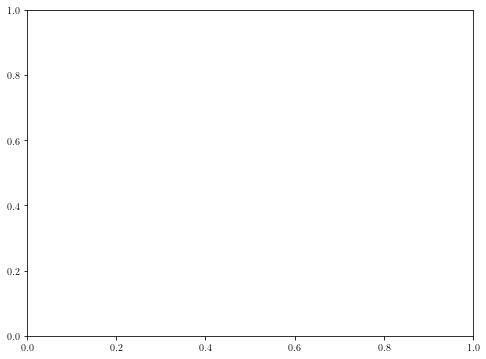

In [30]:
# Now let's plot only the two terms that are approximated with the Hx approximation
fig,ax = plt.subplots(figsize=(8,6))

hxc_xim_t2 = [vHxc_xim_allterms(twot,bigu,deltav,xim)["t2"] for xim in weightlist]
hxc_xim_t3 = [vHxc_xim_allterms(twot,bigu,deltav,xim)["t3"] for xim in weightlist]

hx_xim_t2 = [vHx_xim_allterms(twot,bigu,deltav,xim)["t2"] for xim in weightlist]
hx_xim_t3 = [vHx_xim_allterms(twot,bigu,deltav,xim)["t3"] for xim in weightlist]

hxxim1 = [vHx_xim(twot,bigu,deltav,xim) for xim in weightlist]

ax.plot(weightlist,hxc_xim_t2,label=r"$E_{\rm Hxc}^{\xi_-}(n^{\xi_-})$",color="red",lw=2.0,ls="-.")
ax.plot(weightlist,hxc_xim_t3,label=r"$-(2+\xi_-)\frac{\partial E_{\rm Hxc}^{\xi_-}(n)}{\partial \xi_-}\bigg\vert_{n=n^{\xi_-}}$",
         color="red",lw=2.0,ls=":")

ax.plot(weightlist,hx_xim_t2,label=r"$E_{\rm Hx}^{\xi_-}(n^{\xi_-})$",color="orange",lw=2.0,ls="-.")
ax.plot(weightlist,hx_xim_t3,label=r"$-(2+\xi_-)\frac{\partial E_{\rm Hx}^{\xi_-}(n)}{\partial \xi_-}\bigg\vert_{n=n^{\xi_-}}$",
         color="orange",lw=2.0,ls=":")

hxxim_approx = [0.5*( deltav*(twot*x/np.sqrt(4*(twot**2 + (deltav**2)) - (x*deltav)**2) - 1)*(1 + x*deltav/(2*np.sqrt(twot**2 + deltav**2))) + bigu*(1 + ((x**2)*(deltav**2))/(4*(twot**2 + deltav**2))) ) for x in weightlist]

ax.plot(weightlist,hxxim1,color="brown")
ax.plot(weightlist,hxxim_approx,color="green",ls=":",marker="*",markevery=10)

# Some axis parameters

ax.set_title(r"$t = \:$"+str(twot/2)+", "+r"$U = \:$"+str(bigu)+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
                          y = 1.01,
                          fontsize=22)

ax.set_xlabel(r"$\xi_-$",fontsize=20,labelpad=10)
ax.tick_params(axis='both', direction="in", labelsize=18)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(7))
ax.tick_params(axis='both', which='major', pad=8)
ax.set_xlim(0,2)

#ax.axhline(y=0,color="black")


ax.legend(fontsize=20,bbox_to_anchor=(1.01,1.01))

In [31]:
def hxximapprox(twot,bigu,deltav,x):
    
    return 0.5*( (twot*x/np.sqrt(8-x**2) - deltav)*(1 + x*np.sqrt(2)/4) + bigu*(1 + (x**2)/8) )

In [32]:
vHx_xim(1,5,1,1)

2.4085371119443297

In [33]:
hxximapprox(1,5,1,1)

2.391520851686083

In [34]:
def vHx_w_allterms(twot,bigu,deltav,w):
    
    xim=0
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]

    dxim_EHx = -(bigu/4)*(1 + ( (1-n_ens)/(1-w) )**2)
    
    dw_EHx = (bigu/2)*(1 - ((1 + 3*w + xim)*((1-n_ens)**2)/((1-w)**3)) )
    
    EHX = (bigu/2)*(1 + w - (xim/2) + (1-3*w-(xim/2))*(((1-n_ens)/(1-w))**2) )
    
    return {"t2":EHX,"t3":(2-w)*dw_EHx,"t4":-2*dxim_EHx}

NameError: name 'vHxc_w_allterms' is not defined

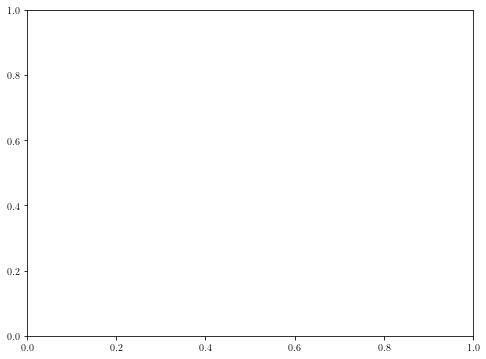

In [35]:
# Now let's plot only the three terms that are approximated with the Hx approximation
weightlist = np.linspace(0,0.5,201)
fig,ax = plt.subplots(figsize=(8,6))

hxc_w_t1 = [vHxc_w_allterms(twot,bigu,deltav,xim)["t1"] for xim in weightlist]
hxc_w_t2 = [vHxc_w_allterms(twot,bigu,deltav,xim)["t2"] for xim in weightlist]
hxc_w_t3 = [vHxc_w_allterms(twot,bigu,deltav,xim)["t3"] for xim in weightlist]
hxc_w_t4 = [vHxc_w_allterms(twot,bigu,deltav,xim)["t4"] for xim in weightlist]

hx_w_t2 = [vHx_w_allterms(twot,bigu,deltav,xim)["t2"] for xim in weightlist]
hx_w_t3 = [vHx_w_allterms(twot,bigu,deltav,xim)["t3"] for xim in weightlist]
hx_w_t4 = [vHx_w_allterms(twot,bigu,deltav,xim)["t4"] for xim in weightlist]


#sumallhx = [(x+y+w+z)/2 for x,y,w,z in zip(hxc_w_t1,hx_w_t2,hx_w_t3,hx_w_t4)]
vhx = [vHx_w(twot,bigu,deltav,w) for w in weightlist]
vhx2 = [vHx_w2(twot,bigu,deltav,w) for w in weightlist]

ax.plot(weightlist,hxc_w_t1,label=r"${\Delta v}_{\rm Hxc}^{\tt w}n^{\tt w}$",color="maroon",lw=2.0,ls="-.")
ax.plot(weightlist,hxc_w_t2,label=r"$E_{\rm Hxc}^{\tt w}(n^{\tt w})$",color="red",lw=2.0,ls="-.")
ax.plot(weightlist,hxc_w_t3,label=r"$(2-\tt w)\frac{\partial E_{\rm Hxc}^{\tt w}(n)}{\partial \tt w}\bigg\vert_{n=n^{\tt w}}$",
         color="red",lw=2.0,ls=":")
ax.plot(weightlist,hxc_w_t4,label=r"$-2\frac{\partial E_{\rm Hxc}^{\boldsymbol\eta}(n^{\tt w})}{\partial {\xi_-}}\bigg\vert_{\xi_-=0}$",color="red",lw=2.0,ls="-")

#ax.plot(weightlist,hx_w_t2,label=r"$E_{\rm Hx}^{\tt w}(n^{\tt w})$",color="orange",lw=2.0,ls="-.")
#ax.plot(weightlist,hx_w_t3,label=r"$(2-\tt w)\frac{\partial E_{\rm Hx}^{\tt w}(n)}{\partial \tt w}\bigg\vert_{n=n^{\tt w}}$",
         #color="orange",lw=2.0,ls=":")
#ax.plot(weightlist,hx_w_t4,label=r"$-2\frac{\partial E_{\rm Hxc}^{\boldsymbol\eta}(n^{\tt w})}{\partial {\xi_-}}\bigg\vert_{\xi_-=0}$",color="orange",lw=2.0,ls="-")

#ax.plot(weightlist,sumallhx,color="blue")
ax.plot(weightlist,vhx,color="green",ls=":",marker="*",markevery=10)
ax.plot(weightlist,vhx2,color="pink",ls=":",marker="x",markevery=20,ms=10)

vhx_approx = [0.5*( ((w/np.sqrt(1-2*w)) - deltav)*(1 + w) + (bigu)*(2 + (3*w-5)*(w**3)/((1-w)**3))) for w in weightlist[:-1]]
ax.plot(weightlist[:-1],vhx_approx,color="gold")

# Some axis parameters

ax.set_title(r"$t = \:$"+str(twot/2)+", "+r"$U = \:$"+str(bigu)+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
                          y = 1.01,
                          fontsize=22)

ax.set_xlabel(r"$\xi_-$",fontsize=20,labelpad=10)
ax.tick_params(axis='both', direction="in", labelsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(7))
ax.tick_params(axis='both', which='major', pad=8)
ax.set_xlim(0,1/2)

#ax.axhline(y=0,color="black")


ax.legend(fontsize=20,bbox_to_anchor=(1.01,1.01))

In [36]:
# Defining control variables for the second plot
twot = 1
bigu = 5
deltav = 1
weightlist = np.linspace(0,0.5,201)

NameError: name 'vHxc_w_allterms' is not defined

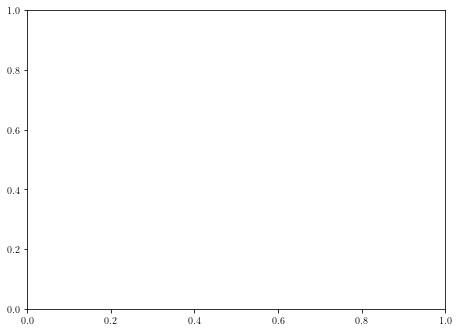

In [37]:
fig,ax = plt.subplots(figsize=(7.5,5.5))

# Hxc potential on site 1, asymmetric case
hxc_w = [2*vHxc_w(twot,bigu,deltav,w) for w in weightlist]

# Hxc potential on site 1, asymmteric case, various terms
hxc_w_t1 = [vHxc_w_allterms(twot,bigu,deltav,w)["t1"] for w in weightlist]
hxc_w_t2 = [vHxc_w_allterms(twot,bigu,deltav,w)["t2"] for w in weightlist]
hxc_w_t3 = [vHxc_w_allterms(twot,bigu,deltav,w)["t3"] for w in weightlist]
hxc_w_t4 = [vHxc_w_allterms(twot,bigu,deltav,w)["t4"] for w in weightlist]

#Check if everything is okay
#allsum = [i+j+k+l for i,j,k,l in zip(hxc_w_t1,hxc_w_t2,hxc_w_t3,hxc_w_t4)]

ax.plot(weightlist,hxc_w,label=r"$2v_{\rm Hxc}^{\tt w}$",color="blue",lw=2.0)

ax.plot(weightlist,hxc_w_t1,label=r"${\Delta v}_{\rm Hxc}^{\tt w}n^{\tt w}$",color="blue",lw=2.0,ls="--")
ax.plot(weightlist,hxc_w_t2,label=r"$E_{\rm Hxc}^{\tt w}(n^{\tt w})$",color="blue",lw=2.0,ls="-.")
ax.plot(weightlist,hxc_w_t3,label=r"$(2-{\tt w})\frac{\partial E_{\rm Hxc}^{\tt w}(n)}{\partial {\tt w}}\bigg\vert_{n=n^{\tt w}}$",
         color="blue",lw=2.0,ls=":")

ax.plot(weightlist,hxc_w_t4,label=r"$-2\frac{\partial E_{\rm Hxc}^{\boldsymbol\eta}(n^{\tt w})}{\partial {\xi_-}}\bigg\vert_{\xi_-=0}$",
         color="blue",lw=2.0,ls=(0, (3, 3, 1, 3, 1, 3)))

#optgap = (bigu - deltav) + 2*((twot/2)**2)*(3*bigu + deltav)/(bigu**2 - deltav**2)
#ax.plot(weightlist,[optgap - twot*np.sqrt(1-2*w) for w in weightlist],color="k")

# Plot the sum of all individual terms
#ax.plot(weightlist,allsum,color="black")

# Some axis parameters

ax.set_title(r"$t = \:$"+str(twot/2)+", "+r"$U = \:$"+str(bigu)+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
                          y = 1.01,
                          fontsize=20)

ax.set_xlabel(r"$\tt w$",fontsize=20,labelpad=10)
ax.tick_params(axis='both', direction="in", labelsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(7))
ax.tick_params(axis='both', which='major', pad=8)
ax.set_xlim(0,0.5)

#ax.axhline(y=-(-np.sqrt(2)/2 + 5/48)*2,color="k")

ax.legend(fontsize=20,ncol=2,loc="lower left",bbox_to_anchor=(0,-0.6),frameon=False)


#plt.savefig("DDiscont_vHxc_w_allterms.pdf",bbox_inches="tight")

### Objective 2: Evaluate the IP's at the exact level

We need to evaluate the two ionization potentials, $I_{1}^{N}$ and $I_{0}^{N}$.

The exact relations are:

$$I_{1}^{N} = E_{0}^{N-1} - E_{0}^{N}$$

and

$$I_{1}^{N} = E_{0}^{N-1} - E_{1}^{N}$$

So that the optical gap can be expressed as

$$\Omega_{1}^{N} = E_{1}^{N} - E_{0}^{N} \\ = I_{0}^{N} - I_{1}^{N}$$

The exact IP relations are as follows:

$$ I_{1}^{N} = \varepsilon_{H}^{\boldsymbol\eta} + 
(1 + \frac{\xi_-}{2})\frac{\partial E_{Hxc}^{\boldsymbol\eta}(n)}{\partial \xi_{-}} \biggr\rvert_{n=n^{\boldsymbol\eta}} +
(\frac{\tt w}{2} - 1)\frac{\partial E_{Hxc}^{\boldsymbol\eta}(n)}{\partial \tt w} \biggr\rvert_{n=n^{\boldsymbol\eta}}+
\frac{1}{2}\bigg[ \Delta v_{Hxc}^{\eta}(1-n^{\eta}) - E_{Hxc}^{\eta}(n^{\eta})\bigg]
$$

$$ I_{0}^{N} = -\varepsilon_{H}^{\boldsymbol\eta} + 
(1 + \frac{\xi_-}{2})\frac{\partial E_{Hxc}^{\boldsymbol\eta}(n)}{\partial \xi_{-}} \biggr\rvert_{n=n^{\boldsymbol\eta}} +
\frac{\tt w}{2}\frac{\partial E_{Hxc}^{\boldsymbol\eta}(n)}{\partial \tt w} \biggr\rvert_{n=n^{\boldsymbol\eta}}+
\frac{1}{2}\bigg[ \Delta v_{Hxc}^{\eta}(1-n^{\eta}) - E_{Hxc}^{\eta}(n^{\eta})\bigg]
$$

where the first term in both Eqs. is the so-called Levy-Zahariev shift in potential

$$
C_{LZ}^{\boldsymbol\eta}(n^{\boldsymbol\eta}) = \frac{1}{2}\bigg[ E_{Hxc}^{\boldsymbol\eta}(n^{\boldsymbol\eta}) - \Delta v_{Hxc}^{\boldsymbol\eta}(1-n^{\boldsymbol\eta}) \bigg]
$$

where $\Delta v_{Hxc}^{\boldsymbol\eta} = \Delta v_{KS}^{\boldsymbol\eta} - \Delta v_{ext}$
and the exact Hxc weight derivatives are simply evaluated from $F^{\boldsymbol\eta}(n) - T_{s}^{\boldsymbol\eta}(n)$ as follows

$$
\frac{\partial E_{Hxc}^{\boldsymbol\eta}(n)}{\partial \tt w}\biggr\rvert_{n=n^{\boldsymbol\eta}}=
E_{1}^{N} - E_{0}^{N} - \frac{2t(1-{\tt w})}{\sqrt{(1-{\tt w})^{2} - (1-n)^{2}}}
$$

and

$$
\frac{\partial E_{Hxc}^{\boldsymbol\eta}(n)}{\partial \tt \xi_-}\biggr\rvert_{n=n^{\boldsymbol\eta}}=
E_{0}^{N-1} - \frac{1}{2}E_{0}^{N}
$$

#### We only need to compute the Levy-Zahariev shift in potential here, all the other quantities are already available

In [38]:
def LZShift(twot,bigu,deltav,xim,w):
    ### Only defined for a given ensemble density!!!
    EHXC = EHxc_eta(twot,bigu,deltav,xim,w)
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    vHxc = deltav_Hxc_eta(twot,bigu,deltav,xim,w)
    
    result = (1/2)*(EHXC - vHxc*(1-n_ens))
    
    return result

In [39]:
# And then we compute the LZShifted KS energies
def eKS_LZShifted(twot,bigu,deltav,xim,w):
    ### Only defined for a given ensemble density!!!
    t = twot/2
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    
    e_Homo = (-t*(1-w))/(sqrt((1-w)**2 - (1-n_ens)**2))
    
    LZS = LZShift(twot,bigu,deltav,xim,w)
    
    e_Homo_LZ = e_Homo + LZS
    
    e_Lumo_LZ = -e_Homo + LZS
    
    result = {"eH_LZ":e_Homo_LZ,"eL_LZ":e_Lumo_LZ}
    
    return result

#### Now we do the EEXX approximations

### Objective 3: Evaluate the IP's at the EEXX level of approximation

The exact exchange (EEXX) level of approximation neglects the correlation effects in the Hxc functional

$$E_{Hxc}^{\boldsymbol\eta}(n) \approx E_{Hx}^{\boldsymbol\eta}(n) \\ =
\frac{U}{2}\bigg[ 1 + {\tt w} - \frac{\xi_-}{2} + (1 - 3{\tt w} - \frac{\xi_-}{2})\frac{(1-n)^{2}}{(1-\tt w)^{2}} \bigg]
$$

Where all the terms that we need (in addition to $E_{Hx}^{\boldsymbol\eta}(n)$) have simple analytical expressions

$$\varepsilon_{H}^{\boldsymbol\eta}(n) = \frac{-t(1-{\tt w})}{\sqrt{(1-{\tt w})^{2} - (1-n)^{2}}}$$

$$\frac{\partial E_{Hx}^{\boldsymbol\eta}(n)}{\partial \xi_{-}} =
-\frac{U}{4}\bigg[1 + \frac{(1-n)^{2}}{(1-{\tt w})^{2}}\bigg]
$$

$$\frac{\partial E_{Hx}^{\boldsymbol\eta}(n)}{\partial \tt w} =
\frac{U}{2}\bigg[1 - \frac{(1 + 3{\tt w} + \xi_-)(1-n)^{2}}{(1-{\tt w})^{3}}\bigg]$$

and (DO NOT USE THIS LAST ONE, USE THE FULL deltav_Hxc_eta FUNCTION INSTEAD, SINCE WE WANT TO STUDY DENSITY FUNCTIONAL ERRORS AT EXACT DENSITIES!!!)

$$
\Delta v_{Hx}^{\boldsymbol\eta}(n) = U\bigg[(1 - 3{\tt w} - \frac{\xi_-}{2})\frac{(1-n)}{(1-{\tt w})^{2}} \bigg]
$$

In [40]:
def IP_EEXX(twot,bigu,deltav,xim,w):
    
    # First we compute the ensemble density and declare some other variables
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    t = twot/2
    
    # Then we compute all the other ingredients
    
    e_Homo = (-t*(1-w))/(sqrt((1-w)**2 - (1-n_ens)**2))
    
    dxim_EHx = -(bigu/4)*(1 + ( (1-n_ens)/(1-w) )**2)
    
    dw_EHx = (bigu/2)*(1 - ((1 + 3*w + xim)*((1-n_ens)**2)/((1-w)**3)) )
    
    deltav_Hxc = deltav_Hxc_eta(twot,bigu,deltav,xim,w)
    
    EHX = (bigu/2)*(1 + w - (xim/2) + (1-3*w-(xim/2))*(((1-n_ens)/(1-w))**2) )
    
    ## We also define all the constituents separately
    
    IPN1_LZSHIFT = e_Homo + (1/2)*(deltav_Hxc*(1-n_ens) - EHX)
    
    IPN0_LZSHIFT = -e_Homo + (1/2)*(deltav_Hxc*(1-n_ens) - EHX)
    
    xim_discont = (1 + (xim/2))*dxim_EHx
    
    IPN1_w_discont = ((w/2) - 1)*dw_EHx
    
    IPN0_w_discont = (w/2)*dw_EHx
    
    # And finally, we compute the two ionization potentials (at the EEXX level)
    
    IPN1 = e_Homo + (1 + (xim/2))*dxim_EHx + ((w/2) - 1)*dw_EHx  + (1/2)*(deltav_Hxc*(1-n_ens) - EHX)
    
    IPN0 = -e_Homo + (1 + (xim/2))*dxim_EHx + (w/2)*dw_EHx  + (1/2)*(deltav_Hxc*(1-n_ens) - EHX)
    
    # And then we store and return the results
    
    result = {"IPN1":IPN1,
              "IPN0":IPN0,
              "e_Homo":e_Homo,
              "IPN1_LZSHIFT":IPN1_LZSHIFT,
              "IPN0_LZSHIFT":IPN0_LZSHIFT,
                "xim_discont":xim_discont,
                "IPN1_w_discont":IPN1_w_discont,
                "IPN0_w_discont":IPN0_w_discont}
    
    return result

### Figure 3.1. IP's at the exact and the EEXX level of approximation, various asymmetry and correlation regimes

In [41]:
twot = 1
w = 0
max_xim = 2*(1-2*w)
weightlist = np.arange(0,max_xim+0.01,0.01)
bigu_deltav_loc_list = [(5,0,0),(0.5,1,1),(1,1,2),(5,1,3)]

In [42]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(14,10))
#fig.suptitle("Ionization energies I0 and I1 in the Hubbard dimer",fontsize=25,y=0.99)

for bigu,deltav,loc in bigu_deltav_loc_list:
    
    ### Exact IP's
    IN1 = E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E1_N"]
    IN0 = E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E0_N"]
    ax.ravel()[loc].axhline(IN1,color="blue",lw=2)
    ax.ravel()[loc].axhline(IN0,color="red",label=r"$I_{0}^{N}$",lw=2)
    
    ### EEXX IP list at w = 0
    IN1_eexx = [IP_EEXX(twot,bigu,deltav,xim,0)["IPN1"] for xim in weightlist]
    IN0_eexx = [IP_EEXX(twot,bigu,deltav,xim,0)["IPN0"] for xim in weightlist]
    #ax.ravel()[loc].plot(weightlist,IN1_eexx,color="blue",ls="--",lw=2)
    #ax.ravel()[loc].plot(weightlist,IN0_eexx,label=r"$I_{0,EEXX}^{N}({\tt w}=0)$",color="red",ls="--",lw=2)
    
    ax.ravel()[loc].plot(weightlist,IN1_eexx,color="blue",ls="-",lw=0.75,marker="x",ms=5,markevery=6)
    ax.ravel()[loc].plot(weightlist,IN0_eexx,label=r"$I_{0,EEXX}^{N}({\tt w}=0)$",color="red",ls="-",lw=0.75,marker="x",ms=5,markevery=6)
    
    ### EEXX IP list at w = 0.2
    #w = 0.2
    #max_xim = 2*(1-2*w)
    #weightlist_2 = np.arange(0,max_xim+0.01,0.01)
    #IN1_eexx_2 = [IP_EEXX(twot,bigu,deltav,xim,w)["IPN1"] for xim in weightlist_2]
    #IN0_eexx_2 = [IP_EEXX(twot,bigu,deltav,xim,w)["IPN0"] for xim in weightlist_2]
    #ax.ravel()[loc].plot(weightlist_2,IN1_eexx_2,color="blue",ls="-.",lw=2)
    #ax.ravel()[loc].plot(weightlist_2,IN0_eexx_2,label=r"$I_{0,EEXX}^{N}({\tt w}=0.2)$",color="red",ls="-.",lw=2)
    
    ### EEXX IP list at w = 0.4
    #w = 0.4
    #max_xim = 2*(1-2*w)
    #weightlist_3 = np.arange(0,max_xim+0.01,0.01)
    #IN1_eexx_3 = [IP_EEXX(twot,bigu,deltav,xim,w)["IPN1"] for xim in weightlist_3]
    #IN0_eexx_3 = [IP_EEXX(twot,bigu,deltav,xim,w)["IPN0"] for xim in weightlist_3]
    #ax.ravel()[loc].plot(weightlist_3,IN1_eexx_3,color="blue",ls=":",lw=2)
    #ax.ravel()[loc].plot(weightlist_3,IN0_eexx_3,label=r"$I_{0,EEXX}^{N}({\tt w}=0.4)$",color="red",ls=":",lw=2)

    
    ### Some general settings for matplotlib
    ax.ravel()[loc].set_title(r"$U = $"+str(bigu)+", "+r"$\Delta v =$"+str(deltav),fontsize=16)
    #twot_label = str(Fraction(float("{:.2f}".format(twot/2))))
    ax.ravel()[loc].set_title(r"$t = \:$"+r"$\tfrac{1}{2}$"+", "+r"$U = \:$"+str(bigu)+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
                          fontsize=18,y=1.02)
    ax.ravel()[loc].set_xlabel(r"$\xi_-$",fontsize=18)
    ax.ravel()[loc].set_ylabel("ionization potential",fontsize=18)
    ax.ravel()[loc].set_xlim(0,2)
    ax.ravel()[loc].tick_params(axis='both', direction="in", labelsize=16)
    ax.ravel()[loc].xaxis.set_major_locator(MaxNLocator(4))
    ax.ravel()[loc].yaxis.set_major_locator(MaxNLocator(7))

    
plt.subplots_adjust(hspace=0.3)
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left',bbox_to_anchor=(0.115,-0.025),ncol=3,fontsize=20,frameon=False);
plt.savefig("IP_xim_w0.pdf",bbox_inches="tight")

RuntimeError: latex was not able to process the following string:
b'$t = \\\\:$$\\\\tfrac{1}{2}$, $U = \\\\:$5, $\\\\Delta v_{\\\\rm ext} = \\\\:$0'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../7d6a008cfff681870aacde65f61d66c3.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 7d6a008cfff681870aacde65f61d66c3.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \tfrac 
                       
l.19 {\rmfamily $t = \:$$\tfrac
                               {1}{2}$, $U = \:$5, $\Delta v_{\rm ext} = \:$0}
No pages of output.
Transcript written on 7d6a008cfff681870aacde65f61d66c3.log.




RuntimeError: latex was not able to process the following string:
b'$t = \\\\:$$\\\\tfrac{1}{2}$, $U = \\\\:$5, $\\\\Delta v_{\\\\rm ext} = \\\\:$0'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../7d6a008cfff681870aacde65f61d66c3.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 7d6a008cfff681870aacde65f61d66c3.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \tfrac 
                       
l.19 {\rmfamily $t = \:$$\tfrac
                               {1}{2}$, $U = \:$5, $\Delta v_{\rm ext} = \:$0}
No pages of output.
Transcript written on 7d6a008cfff681870aacde65f61d66c3.log.




<Figure size 1008x720 with 4 Axes>

In [43]:
# Same figure as before, just broken down into two subfigures.

In [44]:
# First subfigure

In [45]:
twot = 1
w = 0
max_xim = 2*(1-2*w)
weightlist = np.arange(0,max_xim+0.01,0.01)
bigu_deltav_loc_list = [(5,0,0),(5,1,1)]

In [46]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10*(3/4),10))

for bigu,deltav,loc in bigu_deltav_loc_list:
    
    ### Exact IP's
    IN1 = E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E1_N"]
    IN0 = E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E0_N"]
    ax.ravel()[loc].axhline(IN1,color="blue",lw=2)
    ax.ravel()[loc].axhline(IN0,color="red",label="Exact",lw=2)
    
    ### EEXX IP list at w = 0
    IN1_eexx = [IP_EEXX(twot,bigu,deltav,xim,0)["IPN1"] for xim in weightlist]
    IN0_eexx = [IP_EEXX(twot,bigu,deltav,xim,0)["IPN0"] for xim in weightlist]
    #ax.ravel()[loc].plot(weightlist,IN1_eexx,color="blue",ls="--",lw=2)
    #ax.ravel()[loc].plot(weightlist,IN0_eexx,label=r"$I_{0,EEXX}^{N}({\tt w}=0)$",color="red",ls="--",lw=2)
    
    ax.ravel()[loc].plot(weightlist,IN1_eexx,color="blue",ls="-",lw=0.75,marker="x",ms=5,markevery=6)
    ax.ravel()[loc].plot(weightlist,IN0_eexx,label=r"${\rm EEXX}({\tt w}=0)$",color="red",ls="-",lw=0.75,marker="x",ms=5,markevery=6)
    
    ### Some general settings for matplotlib
    #twot_label = str(Fraction(float("{:.2f}".format(twot/2))))
    ax.ravel()[loc].set_title(r"$t = \:$"+r"$\tfrac{1}{2}$"+", "+r"$U = \:$"+str(bigu)+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
                          fontsize=20,y=1.02)
    ax.ravel()[loc].set_xlabel(r"$\xi_-$",fontsize=20)
    ax.ravel()[loc].set_ylabel("ionization potential",fontsize=20)
    ax.ravel()[loc].set_xlim(0,2)
    ax.ravel()[loc].set_ylim(-6,1)
    ax.ravel()[loc].tick_params(axis='both', direction="in", labelsize=18)
    ax.ravel()[loc].xaxis.set_major_locator(MaxNLocator(4))
    ax.ravel()[loc].yaxis.set_major_locator(MaxNLocator(7))
    

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left',bbox_to_anchor=(0.12,-0.08),ncol=3,fontsize=22,frameon=False);

plt.savefig("IP_xim_w0_strongcorr.pdf",bbox_inches="tight")

RuntimeError: latex was not able to process the following string:
b'$t = \\\\:$$\\\\tfrac{1}{2}$, $U = \\\\:$5, $\\\\Delta v_{\\\\rm ext} = \\\\:$0'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../07ac5430a26a2772cd03dbed458f12ee.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 07ac5430a26a2772cd03dbed458f12ee.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \tfrac 
                       
l.19 {\rmfamily $t = \:$$\tfrac
                               {1}{2}$, $U = \:$5, $\Delta v_{\rm ext} = \:$0}
No pages of output.
Transcript written on 07ac5430a26a2772cd03dbed458f12ee.log.




RuntimeError: latex was not able to process the following string:
b'$t = \\\\:$$\\\\tfrac{1}{2}$, $U = \\\\:$5, $\\\\Delta v_{\\\\rm ext} = \\\\:$0'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../07ac5430a26a2772cd03dbed458f12ee.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 07ac5430a26a2772cd03dbed458f12ee.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \tfrac 
                       
l.19 {\rmfamily $t = \:$$\tfrac
                               {1}{2}$, $U = \:$5, $\Delta v_{\rm ext} = \:$0}
No pages of output.
Transcript written on 07ac5430a26a2772cd03dbed458f12ee.log.




<Figure size 540x720 with 2 Axes>

In [47]:
# Second subfigure

In [48]:
twot = 1
w = 0
max_xim = 2*(1-2*w)
weightlist = np.arange(0,max_xim+0.01,0.01)
bigu_deltav_loc_list = [(0.5,1,0),(1,1,1)]

In [49]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10*(3/4),10))

for bigu,deltav,loc in bigu_deltav_loc_list:
    
    ### Exact IP's
    IN1 = E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E1_N"]
    IN0 = E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E0_N"]
    ax.ravel()[loc].axhline(IN1,color="blue",lw=2)
    ax.ravel()[loc].axhline(IN0,color="red",label="Exact",lw=2)
    
    ### EEXX IP list at w = 0
    IN1_eexx = [IP_EEXX(twot,bigu,deltav,xim,0)["IPN1"] for xim in weightlist]
    IN0_eexx = [IP_EEXX(twot,bigu,deltav,xim,0)["IPN0"] for xim in weightlist]
    #ax.ravel()[loc].plot(weightlist,IN1_eexx,color="blue",ls="--",lw=2)
    #ax.ravel()[loc].plot(weightlist,IN0_eexx,label=r"$I_{0,EEXX}^{N}({\tt w}=0)$",color="red",ls="--",lw=2)
    
    ax.ravel()[loc].plot(weightlist,IN1_eexx,color="blue",ls="-",lw=0.75,marker="x",ms=5,markevery=6)
    ax.ravel()[loc].plot(weightlist,IN0_eexx,label=r"${\rm EEXX}({\tt w}=0)$",color="red",ls="-",lw=0.75,marker="x",ms=5,markevery=6)
    
    ### Some general settings for matplotlib
    #twot_label = str(Fraction(float("{:.2f}".format(twot/2))))
    ax.ravel()[loc].set_title(r"$t = \:$"+r"$\tfrac{1}{2}$"+", "+r"$U = \:$"+str(bigu)+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
                          fontsize=20,y=1.02)
    ax.ravel()[loc].set_xlabel(r"$\xi_-$",fontsize=20)
    ax.ravel()[loc].set_ylabel("ionization potential",fontsize=20)
    ax.ravel()[loc].set_xlim(0,2)
    ax.ravel()[loc].tick_params(axis='both', direction="in", labelsize=18)
    ax.ravel()[loc].xaxis.set_major_locator(MaxNLocator(4))
    ax.ravel()[loc].yaxis.set_major_locator(MaxNLocator(7))

ax[0].set_ylim(-1.5,0.5)
ax[1].set_ylim(-2,0.5)

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left',bbox_to_anchor=(0.12,-0.08),ncol=3,fontsize=22,frameon=False);

plt.savefig("IP_xim_w0_midcorr.pdf",bbox_inches="tight")

RuntimeError: latex was not able to process the following string:
b'$t = \\\\:$$\\\\tfrac{1}{2}$, $U = \\\\:$0.5, $\\\\Delta v_{\\\\rm ext} = \\\\:$1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../ae643d8b67898dbe0dd2f2f3610d0c33.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file ae643d8b67898dbe0dd2f2f3610d0c33.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \tfrac 
                       
l.19 {\rmfamily $t = \:$$\tfrac
                               {1}{2}$, $U = \:$0.5, $\Delta v_{\rm ext} = \...
No pages of output.
Transcript written on ae643d8b67898dbe0dd2f2f3610d0c33.log.




RuntimeError: latex was not able to process the following string:
b'$t = \\\\:$$\\\\tfrac{1}{2}$, $U = \\\\:$0.5, $\\\\Delta v_{\\\\rm ext} = \\\\:$1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../ae643d8b67898dbe0dd2f2f3610d0c33.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file ae643d8b67898dbe0dd2f2f3610d0c33.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \tfrac 
                       
l.19 {\rmfamily $t = \:$$\tfrac
                               {1}{2}$, $U = \:$0.5, $\Delta v_{\rm ext} = \...
No pages of output.
Transcript written on ae643d8b67898dbe0dd2f2f3610d0c33.log.




<Figure size 540x720 with 2 Axes>

In [53]:
### Correlation energy, upt2 expansion

In [55]:
def dxim_eCorr_UPT2(twot,bigu,deltav,xim):
    
    n_ens = Density(twot,bigu,deltav,xim,0)["n_ens"]
    t = twot/2
    
    result = ((bigu**2)/(32*t))*((1-(1-n_ens)**2)**(3/2))*(1 + 3*(n_ens-1)**2 - 4*(n_ens-1)**2)
    
    return result

### Figure 3.2. Assessing the importance of the weight derivatives in the Exchange-correlation functional to the evaluation of the I0N and I1N ionization potentials

In [50]:
twot = 1
deltav = 1
w = 0
max_xim = 2*(1-2*w)
bigulist = np.arange(0,6.01,0.01)

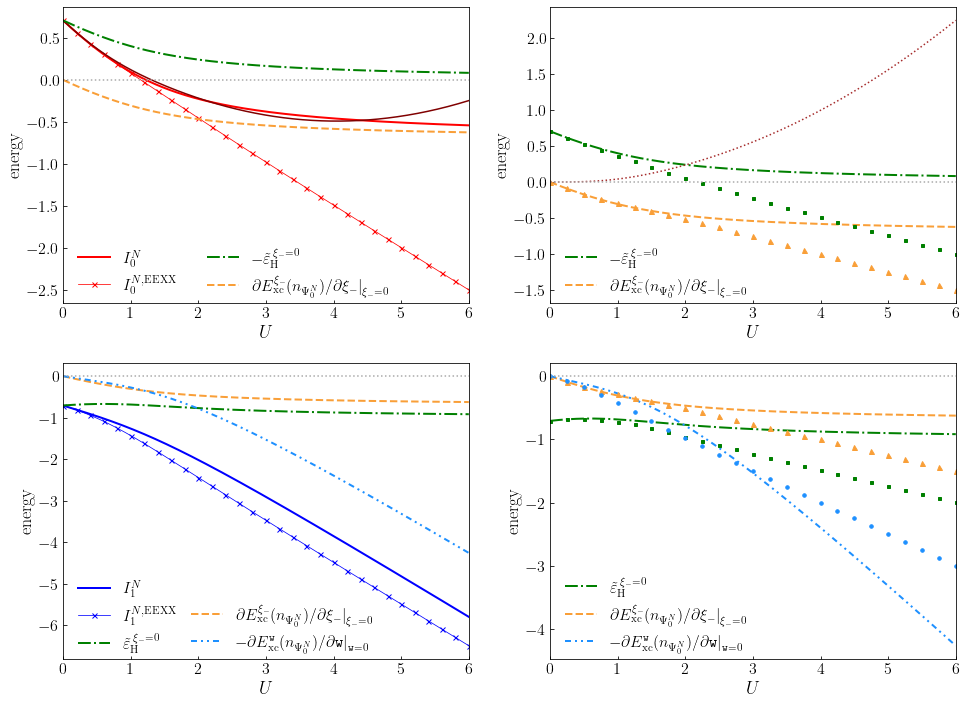

In [58]:
fig1,((ax1,ax3),(ax2,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(16,12))



# TOP LEFT panel: I0_N (ground-state ionization potential)

IN0 = [E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E0_N"] for bigu in bigulist]
#IN0 eexx approximation
IN0_EEXX = [IP_EEXX(twot,bigu,deltav,0,0)["IPN0"] for bigu in bigulist]
#IN0 eexx+upt2 approximation
IN0_UPT2 = [eexx+upt2 for eexx,upt2 in zip(IN0_EEXX,dxim_EC2)]
# -eHomo unshifted
IN0_eH = [-IP_EEXX(twot,bigu,deltav,0,0)["e_Homo"] for bigu in bigulist]
# -eHomo + LZShift contribution
IN0_eHLZ = [-eKS_LZShifted(twot,bigu,deltav,0,0)["eH_LZ"] for bigu in bigulist]
# xim weight derivative contribution, exact
dxim_EHxc = [dxim_EHxc_eta(twot,bigu,deltav,0,0) for bigu in bigulist]



# TOP RIGHT panel: eexx contributions to the LZShift and thee weight derivative

# -eHomo + LZShift contribution, exact exchange approximation
IN0_eHLZ_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["IPN0_LZSHIFT"] for bigu in bigulist]
# xim weight derivative contribution, exchange approximation
dxim_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["xim_discont"] for bigu in bigulist]
# xim weight deriivative contirbution, upt2 approximation
dxim_EC2 = [dxim_eCorr_UPT2(twot,bigu,deltav,0) for bigu in bigulist]


# BOTTOM LEFT panel: I1_N (first-excited state ionization potential)

IN1 = [E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E1_N"] for bigu in bigulist]
#IN0 eexx approximation
IN1_EEXX = [IP_EEXX(twot,bigu,deltav,0,0)["IPN1"] for bigu in bigulist]
# -eHomo unshifted
IN1_eH = [IP_EEXX(twot,bigu,deltav,0,0)["e_Homo"] for bigu in bigulist]
# -eHomo + LZShift contribution
IN1_eHLZ = [-eKS_LZShifted(twot,bigu,deltav,0,0)["eL_LZ"] for bigu in bigulist]
# xim weight derivative contribution, exact
dxim_EHxc = [dxim_EHxc_eta(twot,bigu,deltav,0,0) for bigu in bigulist]
# w weight derivative contribution, exact
dw_EHxc = [-dw_EHxc_eta(twot,bigu,deltav,0,0) for bigu in bigulist]



# BOTTOM RIGHT panel: eexx contributions to the LZShift and thee weight derivative

# -eHomo + LZShift contribution, exact exchange approximation
IN1_eHLZ_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["IPN1_LZSHIFT"] for bigu in bigulist]
# xim weight derivative contribution, exchange approximation
dxim_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["xim_discont"] for bigu in bigulist]
# w weight derivative contribution, exchange approximation
dw_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["IPN1_w_discont"] for bigu in bigulist]

####################################################################################################

# Plotting the things in the TOP LEFT panel
ax1.plot(bigulist,IN0,color="red",label=r"$I_{0}^{N}$",lw=2)
ax1.plot(bigulist,IN0_EEXX,color="red",ls="-",lw=0.75,marker="x",ms=5,markevery=20,label=r"$I_{0}^{N,{\rm EEXX}}$")
ax1.plot(bigulist,IN0_UPT2,color="maroon")
#ax1.plot(bigulist,IN0_eH,color="red",ls="--",label=r"$-\varepsilon_{H}$")
ax1.plot(bigulist,IN0_eHLZ,color="green",ls="-.",label=r"$-\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}$",lw=2)
ax1.plot(bigulist,dxim_EHxc,color="#F99F38",ls="--",label=r"${\partial E_{\rm xc}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$",lw=2)
ax1.axhline(y=0,color="darkgrey",ls=":")

# Plotting the things in the TOP RIGHT panel
#exact stuff
ax3.plot(bigulist,IN0_eHLZ,color="green",ls="-.",label=r"$-\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}$",lw=2)
ax3.plot(bigulist,dxim_EHxc,color="#f99f38",ls="--",label=r"${\partial E_{\rm xc}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$",lw=2)
#eexx approximations
ax3.plot(bigulist,IN0_eHLZ_EHx,color="green",linestyle="None",marker="s",ms=3,markevery=25)
ax3.plot(bigulist,dxim_EHx,color="#f99f38",linestyle="None",marker="^",ms=5,markevery=25)
ax3.plot(bigulist,dxim_EC2,color="brown",ls=":")
ax3.axhline(y=0,color="darkgrey",ls=":")


# Plotting the things in the BOTTOM LEFT panel
ax2.plot(bigulist,IN1,color="blue",label=r"$I_{1}^{N}$",lw=2)
ax2.plot(bigulist,IN1_EEXX,color="blue",ls="-",lw=0.75,marker="x",ms=5,markevery=20,label=r"$I_{1}^{N,{\rm EEXX}}$")
#ax2.plot(bigulist,IN1_eH,color="blue",ls="--",label=r"$\varepsilon_{H}$")
ax2.plot(bigulist,IN1_eHLZ,color="green",ls="-.",label=r"$\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}$",lw=2)
ax2.plot(bigulist,[0 for bigu in bigulist],color="white",label=" ")
ax2.plot(bigulist,dxim_EHxc,color="#F99F38",ls="--",label=r"${\partial E_{\rm xc}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$",lw=2)
ax2.plot(bigulist,dw_EHxc,color="dodgerblue",ls=(0,(3,2,1,2,1,2)),label=r"$-{\partial E_{\rm xc}^{\tt w}(n_{\Psi_0^N})}/{\partial \tt w}\big\vert_{{\tt w}=0}$",lw=2)
ax2.axhline(y=0,color="darkgrey",ls=":")


# Plotting the things in the BOTTOM RIGHT panel
#exct stuff
ax4.plot(bigulist,IN1_eHLZ,color="green",ls="-.",label=r"$\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}$",lw=2)
ax4.plot(bigulist,dxim_EHxc,color="#f99f38",ls="--",label=r"${\partial E_{\rm xc}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$",lw=2)
ax4.plot(bigulist,dw_EHxc,color="dodgerblue",ls=(0,(3,2,1,2,1,2)),label=r"$-{\partial E_{\rm xc}^{\tt w}(n_{\Psi_0^N})}/{\partial \tt w}\big\vert_{{\tt w}=0}$",lw=2)
#eexx approximations
ax4.plot(bigulist,IN1_eHLZ_EHx,color="green",linestyle="None",marker="s",ms=3,markevery=25)
ax4.plot(bigulist,dxim_EHx,color="#f99f38",linestyle="None",marker="^",ms=5,markevery=25)
ax4.plot(bigulist,dw_EHx,color="dodgerblue",linestyle="None",marker=".",ms=7,markevery=25)
ax4.axhline(y=0,color="darkgrey",ls=":")

### Some general settings for matplotlib
#ax1.set_title(r"$t = \:$"+r"$\tfrac{1}{2}$"+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
#                          fontsize=16)
ax1.set_xlabel(r"$U$",fontsize=18)
ax1.set_ylabel("energy",fontsize=18)
ax1.set_xlim(0,6)
ax1.tick_params(axis='both', direction="in", labelsize=16) 

#ax2.set_title(r"$t = \:$"+r"$\tfrac{1}{2}$"+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
#                          fontsize=16)
ax2.set_xlabel(r"$U$",fontsize=18)
ax2.set_ylabel("energy",fontsize=18)
ax2.set_xlim(0,6)
ax2.tick_params(axis='both', direction="in", labelsize=16) 

ax3.set_xlabel(r"$U$",fontsize=18)
ax3.set_ylabel("energy",fontsize=18)
ax3.set_xlim(0,6)
ax3.tick_params(axis='both', direction="in", labelsize=16) 

ax4.set_xlabel(r"$U$",fontsize=18)
ax4.set_ylabel("energy",fontsize=18)
ax4.set_xlim(0,6)
ax4.tick_params(axis='both', direction="in", labelsize=16) 

l1 = ax1.legend(ncol=2,loc="lower left",bbox_to_anchor=(0.001,-0.03),fontsize=16,frameon=False)
l2 = ax2.legend(ncol=2,loc="lower left",bbox_to_anchor=(0.001,-0.03),fontsize=16,columnspacing=1,frameon=False)

l3 = ax3.legend(ncol=1,loc="lower left",bbox_to_anchor=(0.001,-0.03),fontsize=16,frameon=False)
l4 = ax4.legend(ncol=1,loc="lower left",bbox_to_anchor=(0.001,-0.03),fontsize=16,frameon=False)

plt.savefig("IP_bigu_variations.pdf",bbox_inches="tight")


In [67]:
# Same figure as before, just split into two subfigures

In [68]:
twot = 1
deltav = 1
w = 0
max_xim = 2*(1-2*w)
bigulist = np.arange(0,6.01,0.01)

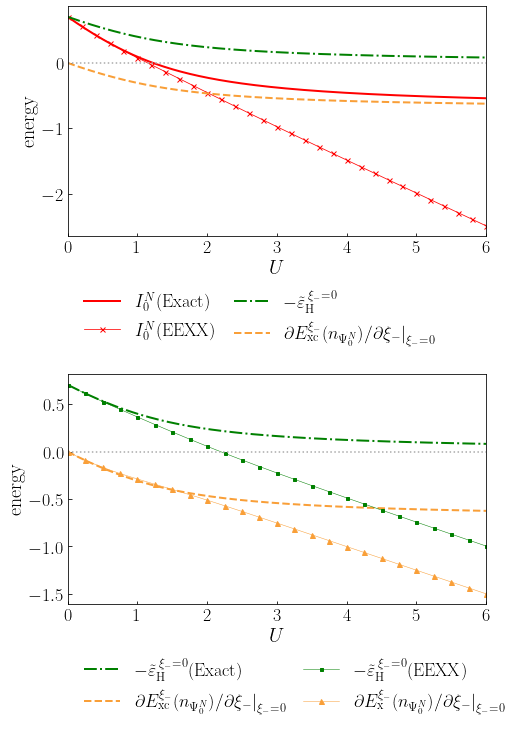

In [69]:
fig1,(ax1,ax3) = plt.subplots(nrows=2,ncols=1,figsize=(10*(3/4),11))



# TOP panel: I0_N (ground-state ionization potential)

IN0 = [E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E0_N"] for bigu in bigulist]
#IN0 eexx approximation
IN0_EEXX = [IP_EEXX(twot,bigu,deltav,0,0)["IPN0"] for bigu in bigulist]
# -eHomo unshifted
IN0_eH = [-IP_EEXX(twot,bigu,deltav,0,0)["e_Homo"] for bigu in bigulist]
# -eHomo + LZShift contribution
IN0_eHLZ = [-eKS_LZShifted(twot,bigu,deltav,0,0)["eH_LZ"] for bigu in bigulist]
# xim weight derivative contribution, exact
dxim_EHxc = [dxim_EHxc_eta(twot,bigu,deltav,0,0) for bigu in bigulist]


# BOTTOM panel: eexx contributions to the LZShift and thee weight derivative

# -eHomo + LZShift contribution, exact exchange approximation
IN0_eHLZ_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["IPN0_LZSHIFT"] for bigu in bigulist]
# xim weight derivative contribution, exchange approximation
dxim_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["xim_discont"] for bigu in bigulist]


# Plotting the things in the TOP panel

ax1.plot(bigulist,IN0,color="red",label=r"$I_{0}^{N}({\rm Exact})$",lw=2)
ax1.plot(bigulist,IN0_EEXX,color="red",ls="-",lw=0.75,marker="x",ms=5,markevery=20,label=r"$I_{0}^{N}({\rm EEXX})$")
#ax1.plot(bigulist,IN0_eH,color="red",ls="--",label=r"$-\varepsilon_{H}$")
ax1.plot(bigulist,IN0_eHLZ,color="green",ls="-.",label=r"$-\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}$",lw=2)
ax1.plot(bigulist,dxim_EHxc,color="#F99F38",ls="--",label=r"${\partial E_{\rm xc}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$",lw=2)
ax1.axhline(y=0,color="darkgrey",ls=":")

# Plotting the things in the TOP RIGHT panel
#exact stuff
ax3.plot(bigulist,IN0_eHLZ,color="green",ls="-.",label=r"$-\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}({\rm Exact})$",lw=2)
ax3.plot(bigulist,dxim_EHxc,color="#f99f38",ls="--",label=r"${\partial E_{\rm xc}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$",lw=2)
#eexx approximations
ax3.plot(bigulist,IN0_eHLZ_EHx,color="green",linestyle="-",lw=0.5,marker="s",ms=3,markevery=25,
        label=r"$-\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}({\rm EEXX})$")
ax3.plot(bigulist,dxim_EHx,color="#f99f38",linestyle="-",lw=0.5,marker="^",ms=5,markevery=25,
        label=r"${\partial E_{\rm x}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$")
ax3.axhline(y=0,color="darkgrey",ls=":")

### Some general settings for matplotlib
#ax1.set_title(r"$t = \:$"+r"$\tfrac{1}{2}$"+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
#                          fontsize=16)
ax1.set_xlabel(r"$U$",fontsize=20)
ax1.set_ylabel("energy",fontsize=20)
ax1.set_xlim(0,6)
ax1.tick_params(axis='both', direction="in", labelsize=18) 

#ax2.set_title(r"$t = \:$"+r"$\tfrac{1}{2}$"+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
#                          fontsize=16)
ax3.set_xlabel(r"$U$",fontsize=20)
ax3.set_ylabel("energy",fontsize=20)
ax3.set_xlim(0,6)
ax3.tick_params(axis='both', direction="in", labelsize=18) 

plt.subplots_adjust(hspace=0.6)

l1 = ax1.legend(ncol=2,loc="lower left",bbox_to_anchor=(0.001,-0.55),fontsize=18,columnspacing=1,frameon=False)
l2 = ax3.legend(ncol=2,loc="lower left",bbox_to_anchor=(0.001,-0.55),fontsize=18,columnspacing=1,frameon=False)


plt.savefig("IPN0_bigu.pdf",bbox_inches="tight")


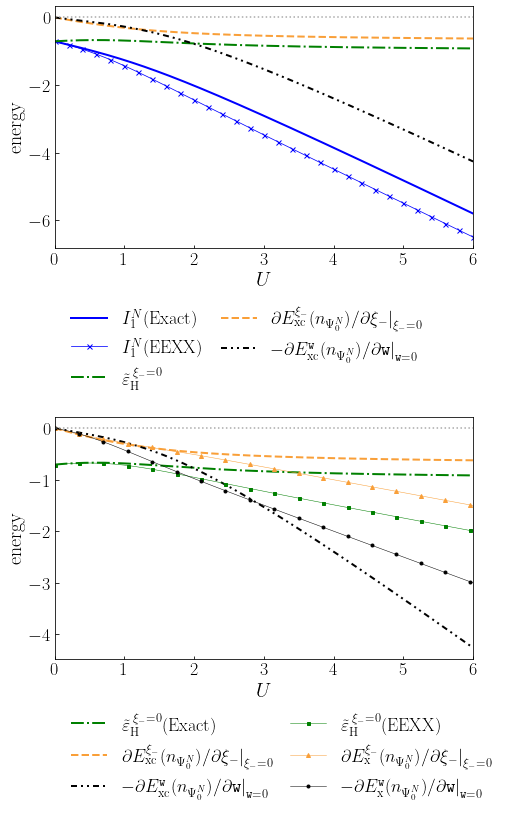

In [70]:
fig1,(ax2,ax4) = plt.subplots(nrows=2,ncols=1,figsize=(10*(3/4),12))


# BOTTOM LEFT panel: I1_N (first-excited state ionization potential)

IN1 = [E(twot,bigu,deltav,0,0)["E0_Nm1"] - E(twot,bigu,deltav,0,0)["E1_N"] for bigu in bigulist]
#IN0 eexx approximation
IN1_EEXX = [IP_EEXX(twot,bigu,deltav,0,0)["IPN1"] for bigu in bigulist]
# -eHomo unshifted
IN1_eH = [IP_EEXX(twot,bigu,deltav,0,0)["e_Homo"] for bigu in bigulist]
# -eHomo + LZShift contribution
IN1_eHLZ = [-eKS_LZShifted(twot,bigu,deltav,0,0)["eL_LZ"] for bigu in bigulist]
# xim weight derivative contribution, exact
dxim_EHxc = [dxim_EHxc_eta(twot,bigu,deltav,0,0) for bigu in bigulist]
# w weight derivative contribution, exact
dw_EHxc = [-dw_EHxc_eta(twot,bigu,deltav,0,0) for bigu in bigulist]



# BOTTOM RIGHT panel: eexx contributions to the LZShift and thee weight derivative

# -eHomo + LZShift contribution, exact exchange approximation
IN1_eHLZ_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["IPN1_LZSHIFT"] for bigu in bigulist]
# xim weight derivative contribution, exchange approximation
dxim_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["xim_discont"] for bigu in bigulist]
# w weight derivative contribution, exchange approximation
dw_EHx = [IP_EEXX(twot,bigu,deltav,0,0)["IPN1_w_discont"] for bigu in bigulist]


# Plotting the things in the BOTTOM LEFT panel
ax2.plot(bigulist,IN1,color="blue",label=r"$I_{1}^{N}({\rm Exact})$",lw=2)
ax2.plot(bigulist,IN1_EEXX,color="blue",ls="-",lw=0.75,marker="x",ms=5,markevery=20,label=r"$I_{1}^{N}({\rm EEXX})$")
#ax2.plot(bigulist,IN1_eH,color="blue",ls="--",label=r"$\varepsilon_{H}$")
ax2.plot(bigulist,IN1_eHLZ,color="green",ls="-.",label=r"$\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}$",lw=2)
#ax2.plot(bigulist,[0 for bigu in bigulist],color="white",label=" ")
ax2.plot(bigulist,dxim_EHxc,color="#F99F38",ls="--",label=r"${\partial E_{\rm xc}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$",lw=2)
ax2.plot(bigulist,dw_EHxc,color="k",ls=(0,(3,2,1,2,1,2)),label=r"$-{\partial E_{\rm xc}^{\tt w}(n_{\Psi_0^N})}/{\partial \tt w}\big\vert_{{\tt w}=0}$",lw=2)
ax2.axhline(y=0,color="darkgrey",ls=":")


# Plotting the things in the BOTTOM RIGHT panel
#exct stuff
ax4.plot(bigulist,IN1_eHLZ,color="green",ls="-.",label=r"$\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}({\rm Exact})$",lw=2)
ax4.plot(bigulist,dxim_EHxc,color="#f99f38",ls="--",label=r"${\partial E_{\rm xc}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$",lw=2)
ax4.plot(bigulist,dw_EHxc,color="k",ls=(0,(3,2,1,2,1,2)),label=r"$-{\partial E_{\rm xc}^{\tt w}(n_{\Psi_0^N})}/{\partial \tt w}\big\vert_{{\tt w}=0}$",lw=2)
#eexx approximations
ax4.plot(bigulist,IN1_eHLZ_EHx,color="green",linestyle="-",lw=0.5,marker="s",ms=3,markevery=35,
        label=r"$\tilde{\varepsilon}_{\rm H}^{\:\xi_- = 0}({\rm EEXX})$")
ax4.plot(bigulist,dxim_EHx,color="#f99f38",linestyle="-",lw=0.5,marker="^",ms=4,markevery=35,
        label=r"${\partial E_{\rm x}^{\xi_-}(n_{\Psi_0^N})}/{\partial \xi_-}\big\vert_{\xi_-=0}$")
ax4.plot(bigulist,dw_EHx,color="k",linestyle="-",marker=".",lw=0.5,ms=6,markevery=35,
        label=r"$-{\partial E_{\rm x}^{\tt w}(n_{\Psi_0^N})}/{\partial {\tt w}}\big\vert_{{\tt w}=0}$")
ax4.axhline(y=0,color="darkgrey",ls=":")



#ax2.set_title(r"$t = \:$"+r"$\tfrac{1}{2}$"+", "+r"$\Delta v_{\rm ext} = \:$"+str(deltav),
#                          fontsize=16)
ax2.set_xlabel(r"$U$",fontsize=20)
ax2.set_ylabel("energy",fontsize=20)
ax2.set_xlim(0,6)
ax2.tick_params(axis='both', direction="in", labelsize=18) 

ax4.set_xlabel(r"$U$",fontsize=20)
ax4.set_ylabel("energy",fontsize=20)
ax4.set_xlim(0,6)
ax4.tick_params(axis='both', direction="in", labelsize=18) 

plt.subplots_adjust(hspace=0.7)

l1 = ax2.legend(ncol=2,loc="lower left",bbox_to_anchor=(0.001,-0.65),fontsize=18,columnspacing=1,frameon=False)
l2 = ax4.legend(ncol=2,loc="lower left",bbox_to_anchor=(0.001,-0.65),fontsize=18,columnspacing=1,frameon=False)


plt.savefig("IPN1_bigu.pdf",bbox_inches="tight")


### Objective 4: Produce surface plots for the ensemble energy, exact and the EEXX approximation, within the allowed set of ensemble weights

Reminder:

The exact expression for the ensemble energy is equal to:

$$ E^{\boldsymbol\eta} = (1 - \frac{\xi_-}{2} - {\tt w})E_{0}^{N} + \xi_{-}E_{0}^{N-1} + {\tt w}E_{1}^{N} $$

While the EEXX expression is equal to:

$$ E^{{\boldsymbol\eta},EEXX} = T_{s}^{\boldsymbol\eta}(n^{\boldsymbol\eta}) + E_{Hx}^{\boldsymbol\eta}(n^{\boldsymbol\eta}) + {\Delta v_{ext}}(1-n^{\boldsymbol\eta})$$

where

$$ T_{s}^{\boldsymbol \eta}(n) = -2t\sqrt{(1-{\tt w})^2 - (1-n)^2} $$

while

$$ E_{Hx}^{\boldsymbol\eta}(n) = \frac{U}{2}\bigg[ 1 + {\tt w} - \frac{\xi_-}{2} + (1 - 3{\tt w} - \frac{\xi_-}{2})\frac{(1-n)^{2}}{(1-\tt w)^{2}} \bigg] $$


the allowed ensemble weight range is:

$$0 \leq \xi_- \leq 2$$

and

$$ 0 \leq {\tt w} \leq \frac{1}{2} - \frac{\xi_-}{4}$$

In [71]:
# First, we define the function for the EEXX ensemble energy

In [78]:
def E_EEXX(twot,bigu,deltav,xim,w):
    
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    
    # The kinetic energy and the EHX functionals
    
    T_s = -twot*sqrt(((1-w)**2) - ((1-n_ens)**2))
    
    E_Hx = (bigu/2)*(1 + w - (xim/2) + (1 - 3*w - (xim/2))*( ((1-n_ens)**2)/((1-w)**2) ) )
    
    result = T_s + E_Hx + deltav*(1-n_ens)
    
    return result

In [31]:
# Ensemble energy, exact and the eexx approximation, comparing both the LIM and the derivative approach to
# extraction of excitation energies.

In [32]:
bigulist = np.linspace(0,6,500)
twot = 1
deltav = 0

In [33]:
def optgap_LIM_EEXX(twot,bigu,deltav):
    
    return 2*(E_EEXX(twot,bigu,deltav,0,1/2)-E_EEXX(twot,bigu,deltav,0,0))
    

In [34]:
def optgap_diff_EEXX(twot,bigu,deltav):
    
    KSGAP = -2*IP_EEXX(twot,bigu,deltav,0,0)["e_Homo"]
    
    n0N = Density(twot,bigu,deltav,0,0)["n0_N"]
    
    wdiff = (bigu/2)*(1 - (1-n0N)**2)
    
    total = KSGAP + wdiff
    
    return {"KSGAP":KSGAP,"total":total}

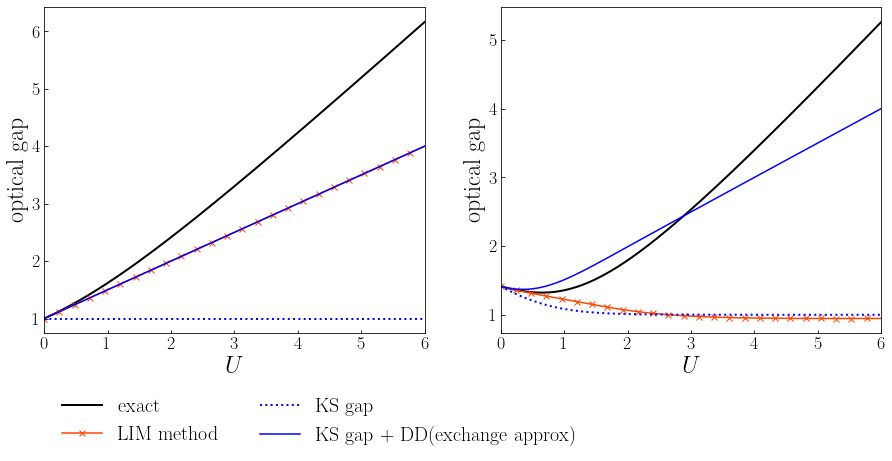

In [35]:
fig,(ax1,ax2) = plt.subplots(figsize=(15,6),ncols=2)

deltav=0
truegaps = [E(twot,bigu,deltav,0,0)["E1_N"]-E(twot,bigu,deltav,0,0)["E0_N"] for bigu in bigulist]
lim_eexx_gaps = [optgap_LIM_EEXX(twot,bigu,deltav) for bigu in bigulist]
diff_eexx_ksgaps = [optgap_diff_EEXX(twot,bigu,deltav)["KSGAP"] for bigu in bigulist]
diff_eexx_optgaps = [optgap_diff_EEXX(twot,bigu,deltav)["total"] for bigu in bigulist]

deltav=1
truegaps2 = [E(twot,bigu,deltav,0,0)["E1_N"]-E(twot,bigu,deltav,0,0)["E0_N"] for bigu in bigulist]
lim_eexx_gaps2 = [optgap_LIM_EEXX(twot,bigu,deltav) for bigu in bigulist]
diff_eexx_ksgaps2 = [optgap_diff_EEXX(twot,bigu,deltav)["KSGAP"] for bigu in bigulist]
diff_eexx_optgaps2 = [optgap_diff_EEXX(twot,bigu,deltav)["total"] for bigu in bigulist]


ax1.set_xlabel(r"$U$",fontsize=24)
ax1.set_ylabel("optical gap",fontsize=24)
ax1.set_xlim(0,6)
ax1.tick_params(axis='both', direction="in", labelsize=18) 

ax2.set_xlabel(r"$U$",fontsize=24)
ax2.set_ylabel("optical gap",fontsize=24)
ax2.set_xlim(0,6)
ax2.tick_params(axis='both', direction="in", labelsize=18) 


ax1.plot(bigulist,truegaps,color="k",lw=2,label="exact")
ax1.plot(bigulist,lim_eexx_gaps,color="orangered",marker="x",markevery=20,label="LIM method")
ax1.plot(bigulist,diff_eexx_ksgaps,color="blue",ls=":",lw=2,label="KS gap")
ax1.plot(bigulist,diff_eexx_optgaps,color="blue",label="KS gap + DD(exchange approx)")

ax2.plot(bigulist,truegaps2,color="k",lw=2)
ax2.plot(bigulist,lim_eexx_gaps2,color="orangered",marker="x",markevery=20)
ax2.plot(bigulist,diff_eexx_ksgaps2,color="blue",ls=":",lw=2)
ax2.plot(bigulist,diff_eexx_optgaps2,color="blue")

ax1.legend(loc="lower left",bbox_to_anchor=(0,-0.4),fontsize=20,ncol=2,frameon=False)
plt.savefig("optgap_comparison.pdf",bbox_inches="tight")

In [ ]:
### The two ionization potentials using the LIM method:

In [54]:
def IP_LIM_EEXX(twot,bigu,deltav):
    
    E0N = E_EEXX(twot, bigu, deltav, 0, 0)
    E_xim2 = E_EEXX(twot, bigu, deltav, 2, 0)
    E_GOK_equiens = E_EEXX(twot, bigu, deltav, 0, 1/2)
    
    
    I0N = (-1/2)*(E0N) + (1/2)*(E_xim2-E0N)
    
    I1N = (-1/2)*(E0N) + (1/2)*(E_xim2-E0N) - 2*(E_GOK_equiens-E0N)
    
    
    return {"I0N":I0N,"I1N":I1N}

In [63]:
def IP_ALTLIM_EEXX(twot,bigu,deltav):
    
    E0N = E_EEXX(twot, bigu, deltav, 0, 0)
    E_xim2 = E_EEXX(twot, bigu, deltav, 2, 0)
    E_GOK_equiens = E_EEXX(twot, bigu, deltav, 0, 1/2)
    
    
    I0N = (-1/2)*E_EEXX(twot,bigu,deltav,1,1/4) + (1/2)*(1+(1/2))*(E_xim2-E0N) + (1/4)*(E_GOK_equiens-E0N)
    
    I1N = (-1/2)*E_EEXX(twot,bigu,deltav,1,1/4) + (1/2)*(1+(1/2))*(E_xim2-E0N) + ((1/8)-1)*2*(E_GOK_equiens-E0N)
    
    
    return {"I0N":I0N,"I1N":I1N}

In [64]:
bigulist = np.linspace(0,6,500)
twot = 1
deltav = 1

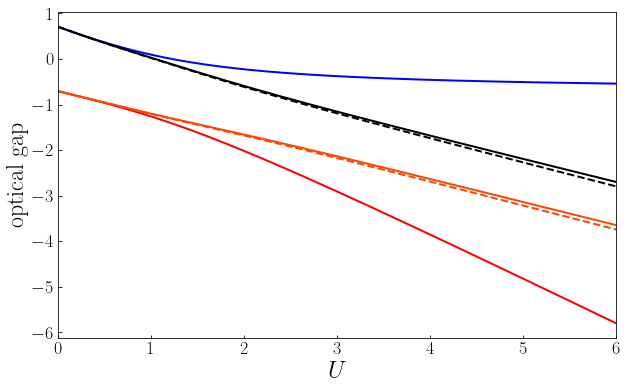

In [65]:
fig,ax = plt.subplots(figsize=(10,6))

I0N_true = [E(twot,bigu,deltav,0,0)["E0_Nm1"]-E(twot,bigu,deltav,0,0)["E0_N"] for bigu in bigulist]
I1N_true = [E(twot,bigu,deltav,0,0)["E0_Nm1"]-E(twot,bigu,deltav,0,0)["E1_N"] for bigu in bigulist]

I0N_LIM_eexx = [IP_LIM_EEXX(twot,bigu,deltav)["I0N"] for bigu in bigulist]
I1N_LIM_eexx = [IP_LIM_EEXX(twot,bigu,deltav)["I1N"] for bigu in bigulist]

I0N_ALTLIM_eexx = [IP_ALTLIM_EEXX(twot,bigu,deltav)["I0N"] for bigu in bigulist]
I1N_ALTLIM_eexx = [IP_ALTLIM_EEXX(twot,bigu,deltav)["I1N"] for bigu in bigulist]

ax.set_xlabel(r"$U$",fontsize=24)
ax.set_ylabel("optical gap",fontsize=24)
ax.set_xlim(0,6)
ax.tick_params(axis='both', direction="in", labelsize=18)

ax.plot(bigulist,I0N_true,color="blue",lw=2,label="IN0 exact")
ax.plot(bigulist,I1N_true,color="red",lw=2,label="IN1 exact")
ax.plot(bigulist,I0N_LIM_eexx,color="k",lw=2,label="IN0 LIM")
ax.plot(bigulist,I1N_LIM_eexx,color="orangered",lw=2,label="IN1 LIM")
ax.plot(bigulist,I0N_ALTLIM_eexx,color="k",lw=2,ls="--",label="IN0 ALTLIM")
ax.plot(bigulist,I1N_ALTLIM_eexx,color="orangered",lw=2,ls="--",label="IN1 ALTLIM")

In [58]:
import plotly.graph_objects as go
import pandas as pd
from ipywidgets import widgets

ModuleNotFoundError: No module named 'plotly'

In [59]:
# Defining the x and y range
xim_list = np.linspace(0,2,100)
w_list = np.linspace(0,0.5,100)

In [202]:
# Defining the model parameters
twot = 1
bigu = 5
deltav = 10

In [203]:
# Defining the z values
z_valueslist_exact = []
z_valueslist_eexx = []

for xim in xim_list:
    z_innerlist_exact = []
    z_innerlist_eexx = []
    for w in w_list:
        if w <= ((1/2) - (xim/4)):
            # Inside the allowed weight region
            E_exact = E(twot,bigu,deltav,xim,w)["E_ens"]
            E_eexx = E_EEXX(twot,bigu,deltav,xim,w)
        else:
            # Outside the allowed weight region
            E_exact = np.NaN
            E_eexx = np.NaN
        z_innerlist_exact.append(E_exact)
        z_innerlist_eexx.append(E_eexx)
    z_valueslist_exact.append(z_innerlist_exact)
    z_valueslist_eexx.append(z_innerlist_eexx)

In [204]:
# Creating the array of energy values
E_ens_exact = pd.DataFrame(index=xim_list,columns=w_list,data=z_valueslist_exact)
E_ens_eexx = pd.DataFrame(index=xim_list,columns=w_list,data=z_valueslist_eexx)

In [205]:
fig = go.Figure(data=[go.Surface(z=E_ens_exact.values, x=xim_list, y=w_list)])


fig = go.Figure(data=[
    go.Surface(z=E_ens_exact.values.T, x=xim_list, y=w_list,
               name="E_ens (EXACT)",
               colorscale="algae",colorbar=dict(len=0.8, x=1.2)),
    go.Surface(z=E_ens_eexx.values.T, x=xim_list, y=w_list,
               name="E_ens (EEXX)",
               opacity=0.6,
               colorscale="reds",
               colorbar=dict(len=0.8, x=1.4)),
])


fig.update_layout(title='Ensemble energy (exact and EEXX approximation), '+'U='+str(bigu)+', deltaV='+str(deltav),
                  scene = dict(
                    xaxis_title="𝜉",
                    yaxis_title="w",
                    zaxis_title='Ensmble energy'),
                  autosize=False,
                  width=1000, height=700,
                  margin=dict(l=65, r=50, b=65, t=90),
                 scene_camera = dict(
                        eye=dict(x=-1.5, y=-1.5, z=1)))
fig.show()

In [56]:
widgets.FloatSlider(
    value=1,
    min=0,
    max=10.0,
    step=0.1,
    description="U",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
widgets.FloatSlider(
    value=1,
    min=0,
    max=10.0,
    step=0.1,
    description=r"$\Delta v$",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

FloatSlider(value=1.0, continuous_update=False, description='$\\Delta v$', max=10.0, readout_format='.1f')

### Objective 5: Produce ensemble energy, its exchange approximation and the delta-PT2 and U-PT2 correlation approximations to the correlation energy

Delta-PT2 and U-pt2 approximations to the correlation energy:


The delta-pt2 approximation is equal to:

$$
e_c^w(n-1)\:=\:
(1-w)\left[1-\sqrt{1+\left(\frac{u}{2}\right)}^2\right]
+\frac{(n-1)^2}{4}\left[\frac{g(u)}{1+w[ug(u)-1]}
-\frac{2(u+1-w(3u+1)}{(1-w)^2}\right] + \mathcal{O}\left\{(n-1)^4\right\}
$$

where

$$
g(u)\:=\:\left(\frac{u}{2}+\sqrt{1+(\frac{u}{2})^2}\right)
\left[1+\left(\frac{u}{2}+\sqrt{1+(\frac{u}{2})^2}\right)^2\right]
$$

while the u-pt2 approximation is equal to:

$$
e_c^w(n-1) = -\frac{u}{2}\left((1-w) - \frac{(3w-1)(n-1)^2}{(1-w)^2}\right) \:\:\: if \:\:\: |n-1|\leq w
$$

$$
e_c^w(n-1) = u|n-1|-\frac{u}{2}\left((1+w) - \frac{(3w-1)(n-1)^2}{(1-w)^2}\right) \:\:\: if \:\:\: w\leq|n-1|\leq 1-w
$$

In [85]:
def E_EEXX(twot,bigu,deltav,xim,w):
    
    n_ens = Density(twot,bigu,deltav,xim,w)["n_ens"]
    
    # The kinetic energy and the EHX functionals
    
    T_s = -twot*sqrt(((1-w)**2) - ((1-n_ens)**2))
    
    E_Hx = (bigu/2)*(1 + w - (xim/2) + (1 - 3*w - (xim/2))*( ((1-n_ens)**2)/((1-w)**2) ) )
    
    result = T_s + E_Hx + deltav*(1-n_ens)
    
    return result

In [95]:
def E_corr_dpt2(twot,bigu,deltav,w):
    
    u = bigu/(twot)
    up = u/2
    d=Density(twot,bigu,deltav,0,w)["n_ens"]-1
    
    # Some intermediate parameters
    h = (up)+np.sqrt(1+up**2)
    g = h*(1+h**2)
    
    # Computing the correlation energy per unit of 2t
    ec = (1-w)*(1-np.sqrt(1+up**2))+\
    ((d**2)/4)*( g/(1+w*(u*g-1)) - (2*(u+1-w*(3*u+1)))/((1-w)**2))
    
    # Obtaining the final result
    result = ec*twot
    
    return result

In [96]:
def E_corr_upt2(twot,bigu,deltav,w):
    
    u = bigu/(twot)
    up = u/2
    d=Density(twot,bigu,deltav,0,w)["n_ens"]-1
    
    if abs(d)<=w:
        result = -up*((1-w) - ((3*w-1)*(d**2)/((1-w)**2)) )
        result *= twot
        return result
    elif w<=abs(d)<=1-w:
        result = u*abs(d)-up*((1+w) - ((3*w-1)*(d**2)/((1-w)**2)) )
        result *= twot
        return result

In [97]:
def E_ens_dpt2(twot,bigu,deltav,w):
    
    result = E_EEXX(twot,bigu,deltav,0,w)+E_corr_dpt2(twot,bigu,deltav,w)
    
    return result

In [98]:
def E_ens_upt2(twot,bigu,deltav,w):
    
    result = E_EEXX(twot,bigu,deltav,0,w)+E_corr_upt2(twot,bigu,deltav,w)
    
    return result

In [111]:
# Quickly plotting some stuff
bigu = 5
twot = 1
deltav = 1
wlist = np.linspace(0,1/2,100)
energylist_true = [
    E(twot,bigu,deltav,0,w)["E_ens"] for w in wlist
]
energylist_dpt2 = [
    E_ens_dpt2(twot,bigu,deltav,w) for w in wlist
]
energylist_upt2 = [
    E_ens_upt2(twot,bigu,deltav,w) for w in wlist
]

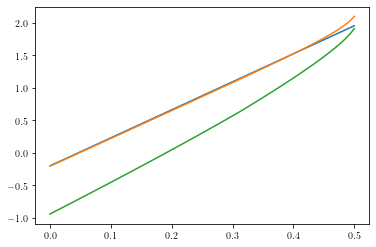

In [112]:
plt.plot(wlist,energylist_true)
plt.plot(wlist,energylist_dpt2)
plt.plot(wlist,energylist_upt2)